In [1]:
%matplotlib inline
import sys
sys.path.append("/home/bianyuan/workspace/Grab_TNGgalaxy/")
# sys.path.append("./Grab_TNGgalaxy")
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import seaborn as sns
from tqdm import tqdm
from Project_galaxy import deIllustrisTNG_galaxy
import h5py
%matplotlib widget
run = 'TNG50'
basePath = '/media/bianyuan/data-TNG-1/' + run + '-1/output'
from astroML.plotting import setup_text_plots
#Lets text in plots use latex
# setup_text_plots(usetex=True)

/home/bianyuan/.conda/envs/py310/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
'''Tranfer SnapNum to Redshift'''

import numpy as np
import h5py, scipy
from pynbody import units as units_conv

Redshift_snapshot = np.loadtxt('/home/bianyuan/workspace/data/Redshift_snapshot.txt',comments='Snapshot')

def redshift_snapshot(snapshots, datafile='/home/bianyuan/workspace/data/Redshift_snapshot.txt', return_opt=None):
    snapshots0, redshifts0 = np.loadtxt(datafile, skiprows=1, unpack=True, usecols=[0, 2])
    n_snap = np.size(snapshots)
    if n_snap == 1: 
        redshifts = redshifts0[np.where(snapshots0 == snapshots)][0]
    elif n_snap >1:
        redshifts = np.zeros(n_snap)
        for ii in range(n_snap): 
            if  snapshots[ii] is np.nan: 
                redshifts[ii] = np.nan
            else:
                redshifts[ii] = redshifts0[np.where(snapshots0 == snapshots[ii])][0]
    if return_opt is None: 
        return redshifts
#   elif return_opt == 'age':
#       return age(redshifts)
    elif return_opt == 'FT':
        return FT(redshifts)

def _a_dot(a, h0, om_m, om_l):                                
    om_k = 1.0 - om_m - om_l      
    return h0 * a * np.sqrt(om_m * (a ** -3) + om_k * (a ** -2) + om_l)  

def _a_dot_recip(*args):
    return 1. / _a_dot(*args) 

# The formation time of stars in unit of Gyr
def FT(redshift, h0=0.6774, OmegaM=0.3089, OmegaL=0.6911):
    conv = units_conv.Unit("0.01 s Mpc km^-1").ratio('Gyr')
    redshift = 1./(1. + redshift)
    ns = np.size(redshift)
    if ns > 1:
        FT = np.zeros(ns)
        for ii in range(ns): FT[ii] = scipy.integrate.quad(_a_dot_recip, 0, redshift[ii], (h0, OmegaM, OmegaL))[0] * conv
    else:
        FT = scipy.integrate.quad(_a_dot_recip, 0, redshift, (h0, OmegaM, OmegaL))[0] * conv
    return FT

In [22]:
import numpy as np
import illustris_python as il
import h5py

def find_local_min_max(distances, Rvir):
    # 找到distances中第一个小于Rvir的索引
    valid_start_index = next((i for i, value in enumerate(distances) if value < Rvir), None)
    
    if valid_start_index is None:
        return []  # 如果没有找到符合条件的索引，则返回空列表
    
    # 查找距离的局部最小点（仅在valid_start_index之后）
    local_min_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    
    local_max_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] > distances[i - 1] and distances[i] > distances[i + 1]]
    
    return local_min_indices, local_max_indices, valid_start_index

def element_ratios(subhalo_id, hdf5_file_path, snap=99):

    H0 = 67.74
    h = H0/100.
    WM = 0.3089
    WV = 0.6911
    Tyr = 977.8
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV
    n=1000
    galaxy = deIllustrisTNG_galaxy(subhalo_id, deproject=True, align_with='star', radius_align_max=10., radius_align_min=0., centmode='pot', snapshot=snap, basePath=basePath, run=run)
    az = galaxy.s['tform'] #scale factor
    age = 0.

    FeH_solar = 10**-4.5
    alphaFe_solar = (10**-3.57+10**-3.31+10**-4.49+10**-4.4+10**-4.07)/10**-4.5
    # 加载恒星数据
    star = il.snapshot.loadSubhalo(basePath, snap, subhalo_id, 'star', fields=['Coordinates','GFM_Metals','GFM_Metallicity','Masses','SubfindDensity','BirthPos'])

    # 提取化学元素的丰度
    H = star['GFM_Metals'][:,0]
    Fe = star['GFM_Metals'][:,8]  # 铁
    C = star['GFM_Metals'][:,2]   # 碳
    O = star['GFM_Metals'][:,4]   # 氧
    Ne = star['GFM_Metals'][:,5]  # 氖
    Mg = star['GFM_Metals'][:,6]  # 镁
    Si = star['GFM_Metals'][:,7]  # 硅

    Subhalo = il.groupcat.loadSingle(basePath, snap, subhaloID=subhalo_id)
    halo = il.groupcat.loadSingle(basePath, snap, haloID=Subhalo['SubhaloGrNr'])
    Rvir = halo['Group_R_Crit200']

    # 计算 Fe/H 和 (C+O+Ne+Mg+Si)/Fe 的比值
    Fe_H = np.log10((Fe/H)/FeH_solar)
    alpha_Fe = np.log10(((C + O + Ne + Mg + Si) / Fe)/alphaFe_solar)

    for j in range(n):
        a = az*(j+0.5)/n
        adot = (WK+(WM/a)+(WR/(a*a))+(WV*a*a))**0.5
        age = age + adot**(-1)
    zage = az*age/n
    zage_Gyr = (Tyr/H0)*zage #this is calculate age
    zage_LBT = FT(redshift_snapshot(99)) - zage_Gyr

    with h5py.File(hdf5_file_path, 'r') as hdf5_file:
        group = hdf5_file[str(subhalo_id)]

        # 读取数据
        numbers = np.array(group['Number'])
        x = np.array(group['x'])
        y = np.array(group['y'])
        z = np.array(group['z'])
        Snap = np.array(group['Snap'])
        Rvir = np.array(group['Rvir'])
        vx = np.array(group['vx'])
        vy = np.array(group['vy'])
        vz = np.array(group['vz'])
        # 计算距离
        distances = np.sqrt(x**2 + y**2 + z**2)
        velocity = np.sqrt(vx**2 + vy**2 + vz**2)
        
        indices = (numbers > 150) & (distances > 0)

        x = x[indices][::-1]
        y = y[indices][::-1]
        z = z[indices][::-1]
        Rvir = Rvir[indices][::-1]
        Snap = Snap[indices][::-1]

        distances = distances[indices][::-1]
        velocity = velocity[indices][::-1]
        
        # 找到近心点和远心点
        local_min, local_max, infall_index = find_local_min_max(distances, Rvir[-1])

    if infall_index is not None:
        infall_time = FT(redshift_snapshot(Snap[np.array(infall_index)]))
    else:
        infall_time = np.nan

    if (local_min is not None) & (len(local_min) > 0):
        pericenters_time = FT(redshift_snapshot(Snap[np.array(local_min)]))
    else:
        pericenters_time = np.nan

    if (local_max is not None) & (len(local_max) > 0):
        apocenters_time = FT(redshift_snapshot(Snap[np.array(local_max)]))
    else:
        apocenters_time = np.nan

    galaxydic={}
    galaxydic['alphaFe']=alpha_Fe
    galaxydic['FeH']=Fe_H
    galaxydic['age']=zage_LBT
    galaxydic['infalltime']=infall_time
    galaxydic['pericenters'] = pericenters_time
    galaxydic['apocenters'] = apocenters_time
    return galaxydic

In [4]:
import numpy as np
import illustris_python as il
import h5py

def element_ratios_for_ND(subhalo_id, snap=99):

    H0 = 67.74
    h = H0/100.
    WM = 0.3089
    WV = 0.6911
    Tyr = 977.8
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV
    n=1000
    galaxy = deIllustrisTNG_galaxy(subhalo_id, deproject=True, align_with='star', radius_align_max=10., radius_align_min=0., centmode='pot', snapshot=snap, basePath=basePath, run=run)
    az = galaxy.s['tform'] #scale factor
    age = 0.

    FeH_solar = 10**-4.5
    alphaFe_solar = (10**-3.57+10**-3.31+10**-4.49+10**-4.4+10**-4.07)/10**-4.5
    # 加载恒星数据
    star = il.snapshot.loadSubhalo(basePath, snap, subhalo_id, 'star', fields=['Coordinates','GFM_Metals','GFM_Metallicity','Masses','SubfindDensity','BirthPos'])

    # 提取化学元素的丰度
    H = star['GFM_Metals'][:,0]
    Fe = star['GFM_Metals'][:,8]  # 铁
    C = star['GFM_Metals'][:,2]   # 碳
    O = star['GFM_Metals'][:,4]   # 氧
    Ne = star['GFM_Metals'][:,5]  # 氖
    Mg = star['GFM_Metals'][:,6]  # 镁
    Si = star['GFM_Metals'][:,7]  # 硅

    Subhalo = il.groupcat.loadSingle(basePath, snap, subhaloID=subhalo_id)
    halo = il.groupcat.loadSingle(basePath, snap, haloID=Subhalo['SubhaloGrNr'])
    Rvir = halo['Group_R_Crit200']

    # 计算 Fe/H 和 (C+O+Ne+Mg+Si)/Fe 的比值
    Fe_H = np.log10((Fe/H)/FeH_solar)
    alpha_Fe = np.log10(((C + O + Ne + Mg + Si) / Fe)/alphaFe_solar)

    for j in range(n):
        a = az*(j+0.5)/n
        adot = (WK+(WM/a)+(WR/(a*a))+(WV*a*a))**0.5
        age = age + adot**(-1)
    zage = az*age/n
    zage_Gyr = (Tyr/H0)*zage #this is calculate age
    zage_LBT = FT(redshift_snapshot(99)) - zage_Gyr

    galaxydic={}
    galaxydic['alphaFe']=alpha_Fe
    galaxydic['FeH']=Fe_H
    galaxydic['age']=zage_LBT
    return galaxydic

In [5]:
import pandas as pd

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
ND = sns.load_dataset('Normal_Dwarf_1',data_home='/home/bianyuan/workspace/data',cache=True)

ND_Iso = np.array(ND['ID'])[np.where( (np.array(ND['Distance']) == 0) )]

with h5py.File('/home/bianyuan/workspace/data/Fingerprint/ND_Iso_finger.hdf5', 'w') as f:
    with tqdm(total=len(ND_Iso)) as pbar:
        for j in ND_Iso:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_ratios_for_ND(j)
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  0%|          | 0/2979 [00:00<?, ?it/s]

/home/bianyuan/.local/lib/python3.10/site-packages/pynbody/array.py:470: RuntimeWarning: invalid value encountered in power
  r = np.asarray(np.power(self.view(np.ndarray), numerical_x)).view(SimArray)
  0%|          | 4/2979 [01:16<15:37:41, 18.91s/it]

In [22]:
import pandas as pd

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRO'''
MRO = pd.read_excel('/home/bianyuan/workspace/data/combine_connect_snap/MRO_connect_snap_data.xlsx')
'''MRI'''
MRI = pd.read_excel('/home/bianyuan/workspace/data/combine_connect_snap/MRI_connect_snap_data.xlsx')

j = MRO['Snap99_ID'][106]

print(j)

with h5py.File('/home/bianyuan/workspace/data/Fingerprint/MRO_finger.hdf5', 'w') as f:
    grp = f.create_group(str(j))
    galaxyd = element_ratios(j,'/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_1.hdf5')
    dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
    dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
    dset = grp.create_dataset('age', data=galaxyd['age'])
    dset = grp.create_dataset('infalltime', data=galaxyd['infalltime'])
    dset = grp.create_dataset('pericenters', data=galaxyd['pericenters'])
    dset = grp.create_dataset('apocenters', data=galaxyd['apocenters'])
    f.close()

499026
Header: {'BoxSize': 35000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 1, 'Ngroups_Total': 10247012, 'Nids_ThisFile': 13513936, 'Nids_Total': 9471772986, 'Nsubgroups_ThisFile': 63864, 'Nsubgroups_Total': 5688113, 'NumFiles': 680, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
dict_keys(['count', 'Coordinates', 'Velocities', 'Masses', 'ParticleIDs', 'GFM_StellarFormationTime'])
dict_keys(['count'])
dict_keys(['count', 'Coordinates', 'Velocities', 'ParticleIDs'])
Main galaxy: 21539 1 641
Keys: ['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass']
Bins: 52 Maximum radius used: 5.225107194427187
Effective radius: 0.5024141533103065 kpc; 0.5291144292564203
rvir,mvir,vvir 24.112754584687625 1498060868.1723633 16.348447608418216
radius_align: 5.024141533103065 24.112754584687625


In [23]:
import pandas as pd

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRO'''
MRO = pd.read_excel('/home/bianyuan/workspace/data/combine_connect_snap/MRO_connect_snap_data.xlsx')
'''MRI'''
MRI = pd.read_excel('/home/bianyuan/workspace/data/combine_connect_snap/MRI_connect_snap_data.xlsx')

with h5py.File('/home/bianyuan/workspace/data/Fingerprint/MRO_finger.hdf5', 'w') as f:
    with tqdm(total=len(MRO['Snap99_ID'])) as pbar:
        for j in MRO['Snap99_ID']:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_ratios(j,'/home/bianyuan/workspace/data/combine_connect_snap/MRO_mergertree_evo_properties_1.hdf5')
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('infalltime', data=galaxyd['infalltime'])
                dset = grp.create_dataset('pericenters', data=galaxyd['pericenters'])
                dset = grp.create_dataset('apocenters', data=galaxyd['apocenters'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

100%|██████████| 107/107 [03:38<00:00,  2.05s/it]


In [17]:
import pandas as pd

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRO'''
MRO = pd.read_excel('/home/bianyuan/workspace/data/combine_connect_snap/MRO_connect_snap_data.xlsx')
'''MRI'''
MRI = pd.read_excel('/home/bianyuan/workspace/data/combine_connect_snap/MRI_connect_snap_data.xlsx')

j = MRI['Snap99_ID'][131]

print(j)

with h5py.File('/home/bianyuan/workspace/data/Fingerprint/MRI_finger.hdf5', 'w') as f:
    grp = f.create_group(str(j))
    galaxyd = element_ratios(j,'/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_1.hdf5')
    dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
    dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
    dset = grp.create_dataset('age', data=galaxyd['age'])
    dset = grp.create_dataset('infalltime', data=galaxyd['infalltime'])
    dset = grp.create_dataset('pericenters', data=galaxyd['pericenters'])
    dset = grp.create_dataset('apocenters', data=galaxyd['apocenters'])
    f.close()

578837
Header: {'BoxSize': 35000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 1, 'Ngroups_Total': 10247012, 'Nids_ThisFile': 13513936, 'Nids_Total': 9471772986, 'Nsubgroups_ThisFile': 63864, 'Nsubgroups_Total': 5688113, 'NumFiles': 680, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
dict_keys(['count', 'Coordinates', 'Velocities', 'Masses', 'ParticleIDs', 'GFM_StellarFormationTime'])
dict_keys(['count', 'Coordinates', 'Velocities', 'Masses', 'ParticleIDs'])
dict_keys(['count', 'Coordinates', 'Velocities', 'ParticleIDs'])
Main galaxy: 8360 1352 1660
Keys: ['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass']
Bins: 30 Maximum radius used: 3.015054776391644
Effective radius: 0.40200730351888586 kpc; 0.5043328952128002
rvir,mvir,vvir 23.578242521185985 1400629512.3964844 15.9860484293641
radius_align: 

In [18]:
import pandas as pd

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRO'''
MRO = pd.read_excel('/home/bianyuan/workspace/data/combine_connect_snap/MRO_connect_snap_data.xlsx')
'''MRI'''
MRI = pd.read_excel('/home/bianyuan/workspace/data/combine_connect_snap/MRI_connect_snap_data.xlsx')

with h5py.File('/home/bianyuan/workspace/data/Fingerprint/MRI_finger.hdf5', 'w') as f:
    with tqdm(total=len(MRI['Snap99_ID'])) as pbar:
        for j in MRI['Snap99_ID']:
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                galaxyd = element_ratios(j,'/home/bianyuan/workspace/data/combine_connect_snap/MRI_mergertree_evo_properties_1.hdf5')
                dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                dset = grp.create_dataset('age', data=galaxyd['age'])
                dset = grp.create_dataset('infalltime', data=galaxyd['infalltime'])
                dset = grp.create_dataset('pericenters', data=galaxyd['pericenters'])
                dset = grp.create_dataset('apocenters', data=galaxyd['apocenters'])
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

100%|██████████| 132/132 [05:43<00:00,  2.60s/it]


In [8]:
import h5py

# 文件路径
file_path = '/home/bianyuan/workspace/data/Fingerprint/ND_Iso_finger.hdf5'

# 打开 HDF5 文件
with h5py.File(file_path, 'r') as file:
    # 列出文件中所有的 group
    def printname(name):
        if isinstance(file[name], h5py.Group):
            print(name)
    
    file.visit(printname)

519720
533998
545003
551541
553230
555815
556304
559711
562338
562742
563050
563471
564825
565537
568303
569877
570598
571072
572457
573413
573738
574883
576705
577924
578541
578834
579509
581308
582344
582612
583256
583451
584007
584875
585079
585517
586420
586836
587256
587500
588647
588986
590012
590385
590569
590926
591210
592662
592984
593904
594246
594556
594731
594887
595442
595661
595994
596400
596660
596986
597141
597311
597530
597934
598320
598539
598696
598840
598988
599244
599465
599651
599865
600096
600363
600743
600946
601123
601194
601522
601693
601861
601997
602130
602330
602509
602820
603004
603281
603554
603826
604241
604371
604516
604667
604855
605054
605279
605482
605844
606038
606223
606405
606541
606820
606907
607117
607310
607530
607712
607863
608061
608228
608528
608745
608903
609001
609152
609461
609710
609891
610017
610157
610361
610532
610668
610819
610988
611152
611385
611524
611780
611958
612241
612388
612699
612825
613006
613209
613358
613552
613808
613990

In [14]:
print(MRI['Snap99_ID'][120])

448833


In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
from scipy.ndimage import gaussian_filter

dex = 0.55

# 定义文件路径
file_paths = {
    'ND_iso_path': '/home/bianyuan/workspace/data/Fingerprint/ND_Iso_finger.hdf5',
    'MP_fl_path': '/home/bianyuan/workspace/data/element_ratios/MP_fl_element_ratios.hdf5',
    'MP_grp_path': '/home/bianyuan/workspace/data/element_ratios/MP_grp_element_ratios.hdf5',
    'MP_cl_path': '/home/bianyuan/workspace/data/element_ratios/MP_cl_element_ratios.hdf5',
    'MRO_finger_path': '/home/bianyuan/workspace/data/Fingerprint/MRO_finger.hdf5',
    'MRI_finger_path': '/home/bianyuan/workspace/data/Fingerprint/MRI_finger.hdf5',
}

# 指定的ID及其对应的文件
specified_ids = {
    '556304': 'ND_iso_path',
    '635674': 'ND_iso_path',
    '676908': 'ND_iso_path',
    '320': 'MRO_finger_path',
    '63990': 'MRO_finger_path',
    '414930': 'MRO_finger_path',
    '148': 'MRI_finger_path',
    '117323': 'MRI_finger_path',
    '448833': 'MRI_finger_path'
}

twilight = plt.get_cmap('twilight_r')

# 创建新的颜色列表：在'twilight' colormap的基础上，将最低值的颜色设置为白色
colors = ["white"] + [twilight(i) for i in range(1, twilight.N)]

# 创建自定义的colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_twilight", colors, N=twilight.N)

# 设置色标映射
norm = mcolors.TwoSlopeNorm(vmin=1e-5, vcenter=10.5, vmax=14)

# 创建图布局
fig, axs = plt.subplots(3, 3, dpi=400, figsize=(18, 15), gridspec_kw={'hspace': 0, 'wspace': 0})
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.90, top=0.94)
axs = axs.flatten()

# 绘制子图
for i, (galaxy_id, file_key) in enumerate(specified_ids.items()):
    path = file_paths[file_key]
    with h5py.File(path, 'r') as file:
        galaxy_group = file[galaxy_id]
        alphaFe = galaxy_group['alphaFe'][:]
        FeH = galaxy_group['FeH'][:]-dex
        age = galaxy_group['age'][:]
        alphaFe, FeH, age = alphaFe[~np.isnan(alphaFe)], FeH[~np.isnan(FeH)], age[~np.isnan(age)]
        hist_range = [[0.5-dex, 3.2-dex], [-0.51, 0.32]]
        extent = [hist_range[0][0], hist_range[0][1], hist_range[1][0], hist_range[1][1]]
        # age_stat, _, _, _ = stats.binned_statistic_2d(FeH, alphaFe, FeH, statistic='count', bins=200, range=hist_range)
        count_stat, xedges, yedges, _ = stats.binned_statistic_2d(
                        FeH, alphaFe, None,  # 使用 None 表示我们只是在计数
                        statistic='count', bins=200, range=hist_range
                    )

        # 计算每个bin的面积
        bin_area = np.diff(xedges)[0] * np.diff(yedges)[0]

        # 计算数密度：每个bin中的点数除以bin的面积
        density_stat = count_stat / bin_area

        smoothed_density = gaussian_filter(density_stat, sigma=1)  # sigma 控制平滑程度

        # 计算总数，用于确定百分比阈值
        total_count = np.sum(density_stat)
        cumulative_density = np.cumsum(np.sort(density_stat.ravel())[::-1])

        # 计算阈值
        thresholds = {}
        for percent in [20, 40, 80]:
            # 找到累积密度首次达到指定百分比的位置
            idx = np.searchsorted(cumulative_density, total_count * percent / 100.0)
            thresholds[percent] = np.sort(density_stat.ravel())[::-1][idx]

        im = axs[i].imshow(np.log1p(density_stat.T), extent=extent, origin='lower', cmap=custom_cmap, aspect='auto', norm=norm)
        axs[i].text(0, -0.5, f'ID {galaxy_id}', fontsize=25, color='black')

        # 在相应的密度阈值上绘制轮廓
        for percent, threshold in thresholds.items():
            # 绘制轮廓线
            CS = axs[i].contour(smoothed_density.T, levels=[threshold], extent=extent, colors=['red', 'blue', 'green'][percent//30-1], linewidths=2)
            CS.collections[0].set_label(f'{percent}%')

# 设置y轴和x轴标签
for i in range(3):
    axs[i * 3].set_ylabel(r'$[\alpha/\mathrm{Fe}]$', fontsize=30)
    axs[6 + i].set_xlabel('[Fe/H]', fontsize=30)

# 仅在外边缘的子图上显示刻度标签
for ax in axs:
    ax.tick_params(axis='both', direction='in', which='both')
    ax.label_outer()
    ax.tick_params(labelsize=20)
    ax.minorticks_on()

# 添加统一的colorbar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), extend='both', 
    orientation='vertical', fraction=0.03, pad=0.03)
# cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, pad=0.03)
cbar.set_label(r'$\log_{10}(1+\mathrm{Density})$', fontsize=30)
cbar.ax.tick_params(labelsize=20)
# 尝试移除 colorbar 边框
cbar.outline.set_edgecolor('none')  # 设置 colorbar 外框线颜色为 'none'
cbar.outline.set_linewidth(0)  # 设置 colorbar 外框线宽度为 0

# 保存整个图像
plt.savefig('/home/bianyuan/workspace/pic/Fingerprint/Combined_9Galaxies_SpecifiedIDs.pdf')
plt.close(fig)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

# 设置范围为 10^3.9 到 10^7.1 的 LogNorm
norm = mcolors.Normalize(vmin=0, vmax=13.8)

# 生成灰色渐变色列表
greys = plt.cm.Greys(np.linspace(0.2, 1, 5))

# 在渐变色列表的开头添加'white'
colors = [(1, 1, 1)] + list(greys)

# 创建新的颜色映射
custom_cmap = LinearSegmentedColormap.from_list("custom_white_grey", colors)

# 创建 ScalarMappable 对象
sm = ScalarMappable(norm=norm, cmap='coolwarm')
sm.set_array([])  # 这一步是必须的，即使我们不使用数据

# 创建一个新的 figure
fig, ax = plt.subplots(figsize=(20, 15))  # 可以调整 figure 的尺寸以适应 colorbar

ax.axis('off')
fig.patch.set_visible(False)

# 创建并显示 colorbar，使用指数表示法
cbar = fig.colorbar(sm, ax=ax, extend='max', orientation='vertical', norm=norm, aspect=10)

# 设置colorbar的标签字体大小
cbar.set_label('Age [Gyr]', size=90)
cbar.ax.tick_params(labelsize=90)

# 尝试移除 colorbar 边框
cbar.outline.set_edgecolor('none')  # 设置 colorbar 外框线颜色为 'none'
cbar.outline.set_linewidth(0)  # 设置 colorbar 外框线宽度为 0
# cbar.ax.set_yticklabels(["$10^{{{:.1f}}}$".format(tick) for tick in cbar.get_ticks()])  # 使用 LaTeX 格式化刻度为指数形式

# plt.gca().set_visible(False)  # 隐藏画布，只显示 colorbar
fig.tight_layout()  # 调整布局以适应 colorbar

# 保存图片
plt.savefig('/home/bianyuan/workspace/pic/age_colorbar.pdf', bbox_inches='tight', pad_inches=0.005, transparent=True)

In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dex = 0.55

# 定义文件路径
file_paths = {
    'ND_iso_path': '/home/bianyuan/workspace/data/Fingerprint/ND_Iso_finger.hdf5',
    'MP_fl_path': '/home/bianyuan/workspace/data/element_ratios/MP_fl_element_ratios.hdf5',
    'MP_grp_path': '/home/bianyuan/workspace/data/element_ratios/MP_grp_element_ratios.hdf5',
    'MP_cl_path': '/home/bianyuan/workspace/data/element_ratios/MP_cl_element_ratios.hdf5',
    'MRO_finger_path': '/home/bianyuan/workspace/data/Fingerprint/MRO_finger.hdf5',
    'MRI_finger_path': '/home/bianyuan/workspace/data/Fingerprint/MRI_finger.hdf5',
}

# 指定的ID及其对应的文件
specified_ids = {
    '556304': 'ND_iso_path',
    '635674': 'ND_iso_path',
    '677382': 'ND_iso_path',
    '320': 'MRO_finger_path',
    '63990': 'MRO_finger_path',
    '414930': 'MRO_finger_path',
    '148': 'MRI_finger_path',
    '117323': 'MRI_finger_path',
    '448833': 'MRI_finger_path'
}

# 显示范围和颜色映射设置
hist_range = [[0.5-dex, 3.2-dex], [-0.51, 0.25]]
extent = [hist_range[0][0], hist_range[0][1], hist_range[1][0], hist_range[1][1]]
# cmap = plt.get_cmap('gray_r')

# 生成灰色渐变色列表
greys = plt.cm.Greys(np.linspace(0.2, 1, 5))

# 在渐变色列表的开头添加'white'
colors = [(1, 1, 1)] + list(greys)

# 创建新的颜色映射
custom_cmap = LinearSegmentedColormap.from_list("custom_white_grey", colors)

norm = mcolors.Normalize(vmin=0, vmax=13.8)

# 创建图布局
fig, axs = plt.subplots(3, 3, figsize=(15, 15), dpi=400, gridspec_kw={'hspace': 0, 'wspace': 0})
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.90, top=0.90)
axs = axs.flatten()

# 绘制子图
for i, (galaxy_id, file_key) in enumerate(specified_ids.items()):
    path = file_paths[file_key]
    with h5py.File(path, 'r') as file:
        galaxy_group = file[galaxy_id]

        if i < 3:
            alphaFe = galaxy_group['alphaFe'][:]
            FeH = galaxy_group['FeH'][:]-dex
            age = galaxy_group['age'][:]

            alphaFe, FeH, age = alphaFe[~np.isnan(alphaFe)], FeH[~np.isnan(FeH)], age[~np.isnan(age)]

            dis_stat, _, _, _ = stats.binned_statistic_2d(FeH, alphaFe, age, statistic='max', bins=200, range=hist_range)
            
            # age_stat, _, _, _ = stats.binned_statistic_2d(FeH, alphaFe, FeH, statistic='count', bins=200, range=hist_range)
            count_stat, xedges, yedges, _ = stats.binned_statistic_2d(
                            FeH, alphaFe, None,  # 使用 None 表示我们只是在计数
                            statistic='count', bins=200, range=hist_range
                        )

            # 计算每个bin的面积
            bin_area = np.diff(xedges)[0] * np.diff(yedges)[0]

            # 计算数密度：每个bin中的点数除以bin的面积
            density_stat = count_stat / bin_area

            smoothed_density = gaussian_filter(density_stat, sigma=1)  # sigma 控制平滑程度

            # 计算总数，用于确定百分比阈值
            total_count = np.sum(density_stat)
            cumulative_density = np.cumsum(np.sort(density_stat.ravel())[::-1])
            
            # 计算阈值
            thresholds = {}
            colors_for_threshold = {
                    20: (177/255,217/255,229/255),
                    40: (71/255,94/255,165/255),
                    80: (52/255,73/255,100/255)
                }
            for percent in [20, 40, 80]:
                # 找到累积密度首次达到指定百分比的位置
                idx = np.searchsorted(cumulative_density, total_count * percent / 100.0)
                thresholds[percent] = np.sort(density_stat.ravel())[::-1][idx]

            im_age = axs[i].imshow(dis_stat.T, extent=extent, origin='lower', cmap='coolwarm', aspect='auto', norm=norm)
            axs[i].text(0, -0.5, f'ID {galaxy_id}', fontsize=25, color='black')
            # cbar = fig.colorbar(im_age, ax=axs.ravel().tolist(), extend='both', orientation='vertical', fraction=0.03, pad=0.03)
            # 在相应的密度阈值上绘制轮廓
            for percent, threshold in thresholds.items():
                # 绘制轮廓线
                contour_color = colors_for_threshold[percent]
                CS = axs[i].contour(smoothed_density.T, levels=[threshold], extent=extent, colors=[contour_color], linewidths=2)
                # 在轮廓线上标注百分比
                CS.collections[0].set_label(f'{percent}%')

        else:       
            alphaFe = galaxy_group['alphaFe'][:]
            FeH = galaxy_group['FeH'][:]-dex
            age = galaxy_group['age'][:]
            pericenters = galaxy_group['pericenters'][:]
            apocenters = galaxy_group['apocenters'][:]
            infalltime = galaxy_group['infalltime'][()]
            first_apocenter_time = apocenters[0]
            second_apocenter_time = apocenters[1]

            # 过滤 NaN 值
            mask = ~np.isnan(alphaFe) & ~np.isnan(FeH) & ~np.isnan(age)

            # 计算时间条件
            time_condition = 13.8 - age[mask]
            infall_condition = time_condition < infalltime
            first_apocenter_condition = (time_condition >= infalltime) & (time_condition < first_apocenter_time)
            second_apocenter_condition = (time_condition >= first_apocenter_time) & (time_condition < second_apocenter_time)
            beyond_condition = (time_condition >= second_apocenter_time)

            # 对每个条件绘制数密度图
            # for condition, cmap in zip([infall_condition, first_apocenter_condition, second_apocenter_condition, beyond_condition], 
            #                     [mpl.colors.ListedColormap(['none','red']), mpl.colors.ListedColormap(['none','yellow']), mpl.colors.ListedColormap(['none','blue']), mpl.colors.ListedColormap(['none','purple'])]):
            for condition, cmap in zip([beyond_condition,second_apocenter_condition,first_apocenter_condition,infall_condition], 
                                [mpl.colors.ListedColormap(['none',(55/255,103/255,149/255)]), mpl.colors.ListedColormap(['none',(114/255,188/255,213/255)]), mpl.colors.ListedColormap(['none',(255/255,208/255,111/255)]), mpl.colors.ListedColormap(['none',(231/255,98/255,84/255)])]):
                
                # 根据时间条件过滤数据
                FeH_cond = FeH[mask][condition]
                alphaFe_cond = alphaFe[mask][condition]
                
                # 统计数据
                stat, xedge, yedge, binnumber = stats.binned_statistic_2d(FeH_cond, alphaFe_cond, 
                                                                            alphaFe_cond, statistic='count', bins=200, range=hist_range)
                count_stat, xedges, yedges, _ = stats.binned_statistic_2d(
                            FeH, alphaFe, None,  # 使用 None 表示我们只是在计数
                            statistic='count', bins=200, range=hist_range
                        )

                # 计算每个bin的面积
                bin_area = np.diff(xedges)[0] * np.diff(yedges)[0]

                # 计算数密度：每个bin中的点数除以bin的面积
                density_stat = count_stat / bin_area

                smoothed_density = gaussian_filter(density_stat, sigma=1)  # sigma 控制平滑程度

                # 计算总数，用于确定百分比阈值
                total_count = np.sum(density_stat)
                cumulative_density = np.cumsum(np.sort(density_stat.ravel())[::-1])
                
                # 计算阈值
                thresholds = {}
                colors_for_threshold = {
                    20: (177/255,217/255,229/255),
                    40: (71/255,94/255,165/255),
                    80: (52/255,73/255,100/255)
                }
                for percent in [20, 40, 80]:
                    # 找到累积密度首次达到指定百分比的位置
                    idx = np.searchsorted(cumulative_density, total_count * percent / 100.0)
                    thresholds[percent] = np.sort(density_stat.ravel())[::-1][idx]

                data = stat.T
                data[data == 0] = np.nan  # 假设小于0.5的数据点是"没有数据"的地方
                data[data > 0] = 1
                mask1 = np.isnan(data)
                color_data = np.zeros_like(data)
                color_data[~mask1] = 1
                im_time = axs[i].imshow(color_data, extent=extent, origin='lower', cmap=cmap, aspect='auto')
                for percent, threshold in thresholds.items():
                    # 绘制轮廓线
                    contour_color = colors_for_threshold[percent]
                    CS = axs[i].contour(smoothed_density.T, levels=[threshold], extent=extent, colors=[contour_color], linewidths=2)
                    # 在轮廓线上标注百分比
                    CS.collections[0].set_label(f'{percent}%')

            axs[i].text(0, -0.5, f'ID {galaxy_id}', fontsize=25, color='black')

            # 定义范围
            axs[i].set_xlim(0.5-dex, 3.2-dex)
            axs[i].set_ylim(-0.51, 0.25)
        
# 设置y轴和x轴标签
for i in range(3):
    axs[i * 3].set_ylabel(r'$\langle [\alpha/\mathrm{Fe}] \rangle$', fontsize=30)
    axs[6 + i].set_xlabel(r'$\langle \mathrm{[Fe/H]} \rangle$', fontsize=30)

# 仅在外边缘的子图上显示刻度标签
for ax in axs:
    ax.tick_params(axis='both', direction='in', which='both')
    ax.label_outer()
    ax.tick_params(labelsize=20)
    ax.minorticks_on()

# # 创建一个颜色映射和范围norm来表示你的颜色
# cmap = mpl.colors.ListedColormap([(231/255,98/255,84/255), (255/255,208/255,111/255), (114/255,188/255,213/255), (55/255,103/255,149/255)])
# bounds = [0, 1, 2, 3, 4]  # 你可以根据需要调整这个范围
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# # 创建一个colorbar
# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs.ravel().tolist(), ticks=[1, 2, 3], extend='both', 
#         orientation='vertical', fraction=0.03, pad=0.03)

# # 设置colorbar的标签，反映在颜色接缝处
# cb.set_ticklabels([f'$t_{{\mathrm{{infall}}}}$',
#                 f'$t_{{1^{{\mathrm{{st}}}}{{\mathrm{{apo}}}}}}$',
#                 f'$t_{{2^{{\mathrm{{nd}}}}{{\mathrm{{apo}}}}}}$'])
# cb.ax.tick_params(labelsize=30)

# cb.set_label('$t_{\mathrm{form}}$',fontsize=35)
# cb.outline.set_edgecolor('none')  # 设置 colorbar 外框线颜色为 'none'
# cb.outline.set_linewidth(0)  # 设置 colorbar 外框线宽度为 0

# 保存整个图像
plt.savefig('/home/bianyuan/workspace/pic/Fingerprint/Combined_9Galaxies_SpecifiedIDs_Formtime.pdf')
plt.close(fig)

In [3]:
file_paths = {
    'ND_Iso_finger_path': '/home/bianyuan/workspace/data/Fingerprint/ND_Iso_finger.hdf5',
}

# 模拟数据加载过程
# 注意：请根据实际数据和文件路径调整
CSSs3 = sns.load_dataset('CSSs3', data_home='/home/bianyuan/workspace/data', cache=True)

ND = sns.load_dataset('Normal_Dwarf_1',data_home='/home/bianyuan/workspace/data',cache=True)

ND_Iso = np.array(ND['ID'])[np.where( (np.array(ND['Distance']) == 0) )]

filtered_ids = ND_Iso

ND_Iso_FeH_scatter_list = []
ND_Iso_alphaFe_scatter_list = []

# 读取数据
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        for galaxy_id in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            if str(galaxy_id) in hdf_file:
                group = hdf_file[str(galaxy_id)]

                # 假设的时间点数据
                FeH = np.array(group['FeH'])
                alphaFe = np.array(group['alphaFe'])

                # 计算 FeH 和 alphaFe 的标准差（scatter）
                FeH_scatter = np.std(FeH)
                alphaFe_scatter = np.std(alphaFe)

                ND_Iso_FeH_scatter_list.append(FeH_scatter)
                ND_Iso_alphaFe_scatter_list.append(alphaFe_scatter)

Processing ND_Iso_finger_path: 100%|██████████| 2979/2979 [00:06<00:00, 476.63it/s]


In [8]:
file_paths = {
    'MRO_finger_path': '/home/bianyuan/workspace/data/Fingerprint/MRO_finger.hdf5',
    'MRI_finger_path': '/home/bianyuan/workspace/data/Fingerprint/MRI_finger.hdf5',
}

# 模拟数据加载过程
# 注意：请根据实际数据和文件路径调整
CSSs3 = sns.load_dataset('CSSs3', data_home='/home/bianyuan/workspace/data', cache=True)
filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')

filtered_ids = np.array(CSSs3['ID'])[(filter_condition_TS) | (filter_condition_BSF)]

# 初始化结果字典
results = {}

FeH_scatter_list = []
alphaFe_scatter_list = []

# 读取数据
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        for galaxy_id in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            if str(galaxy_id) in hdf_file:
                group = hdf_file[str(galaxy_id)]

                # 假设的时间点数据
                FeH = np.array(group['FeH'])
                alphaFe = np.array(group['alphaFe'])

                # 计算 FeH 和 alphaFe 的标准差（scatter）
                FeH_scatter = np.std(FeH)
                alphaFe_scatter = np.std(alphaFe)

                FeH_scatter_list.append(FeH_scatter)
                alphaFe_scatter_list.append(alphaFe_scatter)

                results[galaxy_id] = {'FeH_scatter': FeH_scatter, 'alphaFe_scatter': alphaFe_scatter}

Processing MRO_finger_path:   0%|          | 0/227 [00:00<?, ?it/s]

Processing MRI_finger_path: 100%|██████████| 227/227 [00:00<00:00, 1630.04it/s]


In [9]:
import pandas as pd

# 加载CSSs3.csv文件为DataFrame
csss3_df = pd.read_csv('/home/bianyuan/workspace/data/CSSs3.csv')  # 请将 'path/to/CSSs3.csv' 替换为实际的文件路径

# 更新DataFrame中的BSF_strength和TS_strength列
for galaxy_id, strengths in results.items():
    # 找到DataFrame中对应galaxy_id的行索引
    index = csss3_df[csss3_df['ID'] == galaxy_id].index
    # 如果找到对应的galaxy_id，则更新其BSF_strength和TS_strength列
    if not index.empty:
        csss3_df.at[index[0], 'FeH_scatter'] = strengths['FeH_scatter']
        csss3_df.at[index[0], 'alphaFe_scatter'] = strengths['alphaFe_scatter']

# 保存更新后的DataFrame到新文件或覆盖原文件
csss3_df.to_csv('/home/bianyuan/workspace/data/CSSs3.csv', index=True)  # 选择合适的文件路径

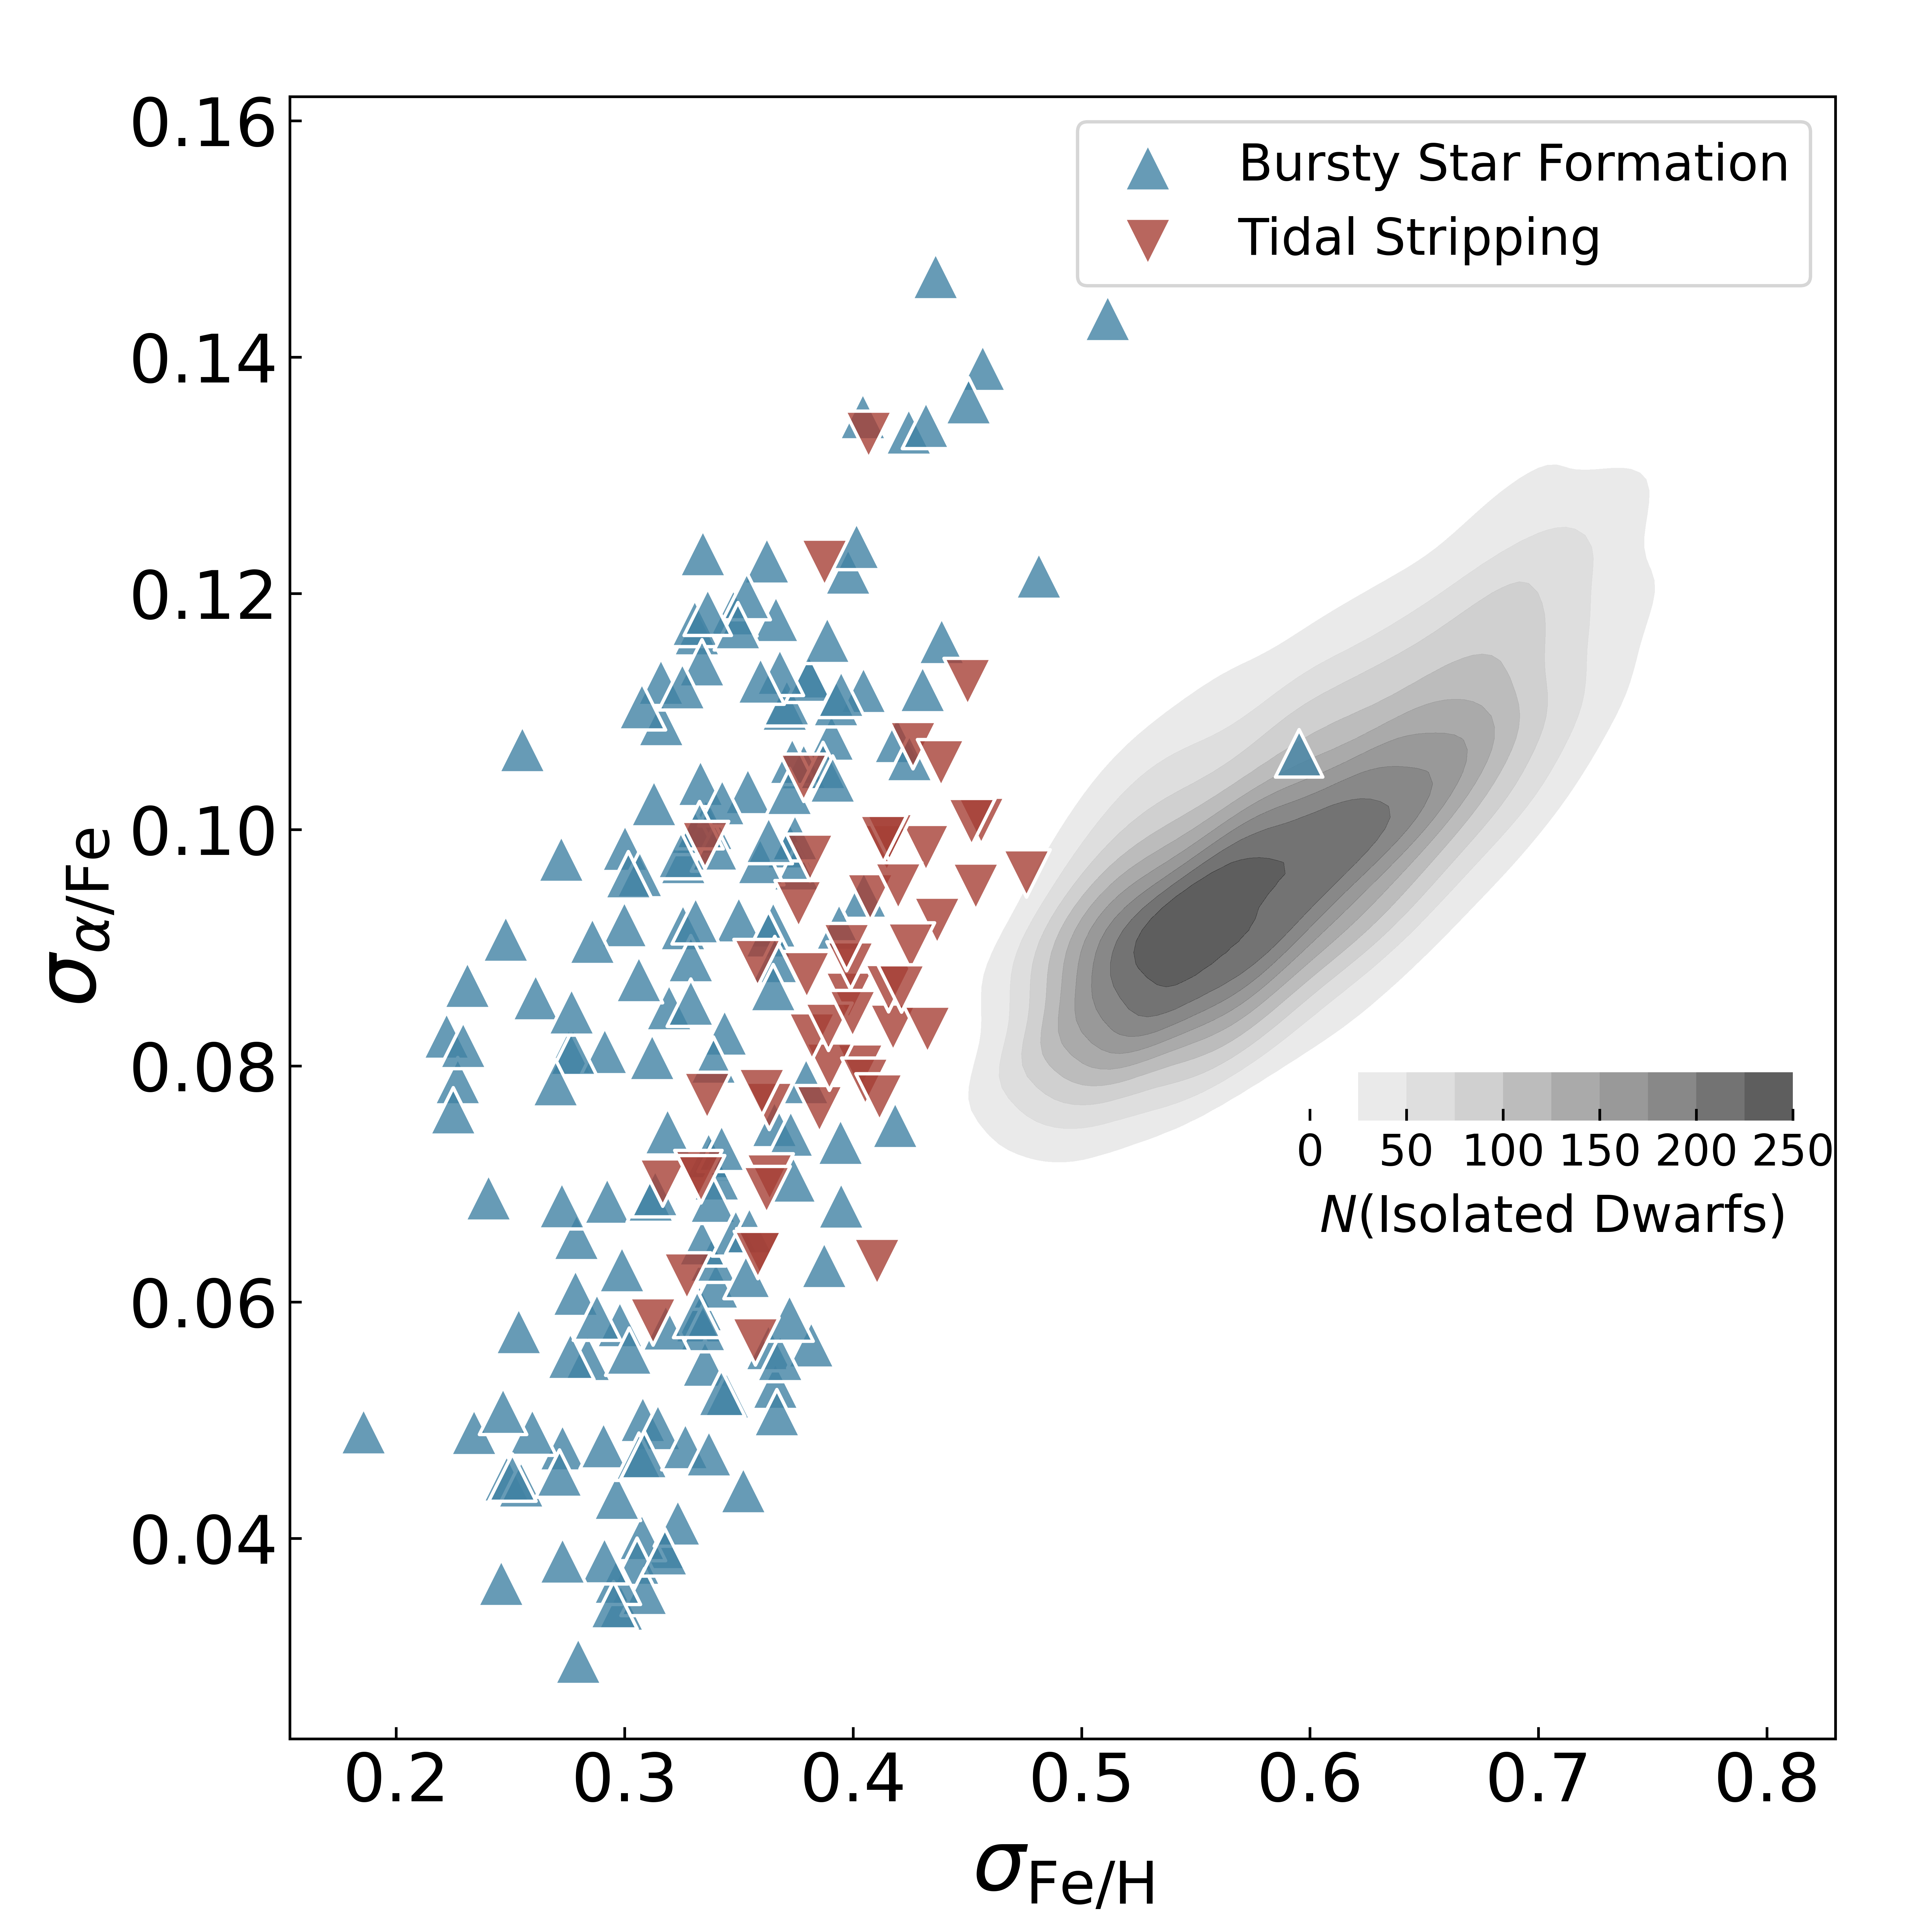

In [5]:
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

grp = (65/255,130/255,164/255,0.8)
cl = (166/255,64/255,54/255,0.8)

CSSs3 = sns.load_dataset('CSSs3', data_home='/home/bianyuan/workspace/data', cache=True)
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')

FeH_scatter_TS = np.array(CSSs3['FeH_scatter'])[(filter_condition_TS)]
alphaFe_scatter_TS = np.array(CSSs3['alphaFe_scatter'])[(filter_condition_TS)]
FeH_scatter_BSF = np.array(CSSs3['FeH_scatter'])[(filter_condition_BSF)]
alphaFe_scatter_BSF = np.array(CSSs3['alphaFe_scatter'])[(filter_condition_BSF)]

fig = plt.figure(figsize=(8,8),dpi=800)

plt.subplots_adjust(left=0.15, bottom=0.1, right=0.95, top=0.95)

plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内

plt.tick_params(axis='x', which='both', labelsize=20)
plt.tick_params(axis='y', which='both', labelsize=20)
plt.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)

# 从CSSs3中提取数据
x = np.array(ND_Iso_FeH_scatter_list)
y = np.array(ND_Iso_alphaFe_scatter_list)

# 检查是否包含NaN或inf，并删除这些数据点
valid_idx = np.logical_and(~np.isnan(x), ~np.isnan(y))
valid_idx = np.logical_and(valid_idx, ~np.isinf(x))
valid_idx = np.logical_and(valid_idx, ~np.isinf(y))
x = x[valid_idx]
y = y[valid_idx]

# 估算密度分布
kernel = gaussian_kde(np.vstack([x, y]))
xmin, ymin = x.min(), y.min()
xmax, ymax = x.max(), y.max()

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

# 生成网格数据
X, Y = np.meshgrid(xi,yi)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((X.ravel(), Y.ravel()), Z.ravel(), (xi, yi), method='cubic')

# 将最低值颜色映射设置为白色
colors = ['white'] + list(plt.cm.Greys(np.linspace(0.2, 1, 10)))  # 使用渐变色设置颜色映射

sm = plt.contourf(xi, yi, zi, levels=10, colors=colors, alpha=0.7)

# plt.scatter(ND_Iso_FeH_scatter_list, ND_Iso_alphaFe_scatter_list, marker='x', s=200, color='lightgrey', edgecolor='white', label='Isolated Ordinary Dwarfs')
plt.scatter(FeH_scatter_BSF, alphaFe_scatter_BSF, marker='^', s=200, color=grp, edgecolor='white', label='Bursty Star Formation')
plt.scatter(FeH_scatter_TS, alphaFe_scatter_TS, marker='v', s=200, color=cl, edgecolor='white', label='Tidal Stripping')

plt.xlabel(r'$\sigma_{\mathrm{Fe/H}}$', fontsize=25)
plt.ylabel(r'$\sigma_{\alpha/\mathrm{Fe}}$', fontsize=25)

plt.legend(fontsize=15)

# 添加colorbar
cax = fig.add_axes([0.678, 0.42, 0.25, 0.025])  # 调整colorbar的位置和大小
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal',cmap='Greys')
cbar.set_label(r'$N(\mathrm{Isolated\ Dwarfs})$', fontsize=15)
cbar.ax.tick_params(labelsize=13)
cbar.outline.set_edgecolor('none')  # 设置 colorbar 外框线颜色为 'none'
cbar.outline.set_linewidth(0)  # 设置 colorbar 外框线宽度为 0
# cbar.set_ticks([])
cbar.ax.xaxis.set_label_coords(0.5, -1.5)  # Increase the y-coordinate value (-1.2 in this example)

plt.savefig('/home/bianyuan/workspace/pic/FeH_alphaFe_scatter.pdf')

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 创建一个颜色映射和范围norm来表示你的颜色
cmap = mpl.colors.ListedColormap([(231/255,98/255,84/255), (255/255,208/255,111/255), (114/255,188/255,213/255), (55/255,103/255,149/255)])
bounds = [0, 1, 2, 3, 4]  # 你可以根据需要调整这个范围
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# 创建图布局
fig, axs = plt.subplots(figsize=(20, 15), dpi=600, gridspec_kw={'hspace': 0, 'wspace': 0})
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.90, top=0.94)
# axs = axs.flatten()

# fig, ax = plt.subplots()

# axs.axis('off')
# fig.patch.set_visible(False)
plt.gca().set_visible(False)  # 隐藏画布，只显示 colorbar

# 创建一个colorbar
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=[1, 2, 3], extend='both', 
        orientation='vertical', fraction=0.03, pad=0.03)

# 设置colorbar的标签，反映在颜色接缝处
cb.set_ticklabels([f'$t_{{\mathrm{{infall}}}}$',
                f'$t_{{1^{{\mathrm{{st}}}}{{\mathrm{{apo}}}}}}$',
                f'$t_{{2^{{\mathrm{{nd}}}}{{\mathrm{{apo}}}}}}$'])
cb.ax.tick_params(labelsize=30)

cb.set_label('$t_{\mathrm{form}}$',fontsize=35)
cb.outline.set_edgecolor('none')  # 设置 colorbar 外框线颜色为 'none'
cb.outline.set_linewidth(0)  # 设置 colorbar 外框线宽度为 0

plt.savefig('/home/bianyuan/workspace/pic/Fingerprint/Combined_9Galaxies_SpecifiedIDs_Formtime_label.pdf')

Processing MRO_path:  31%|███▏      | 15/48 [00:04<00:08,  3.69it/s]/tmp/ipykernel_16581/3937328112.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 8))
Processing MRO_path: 100%|██████████| 48/48 [00:11<00:00,  4.24it/s]


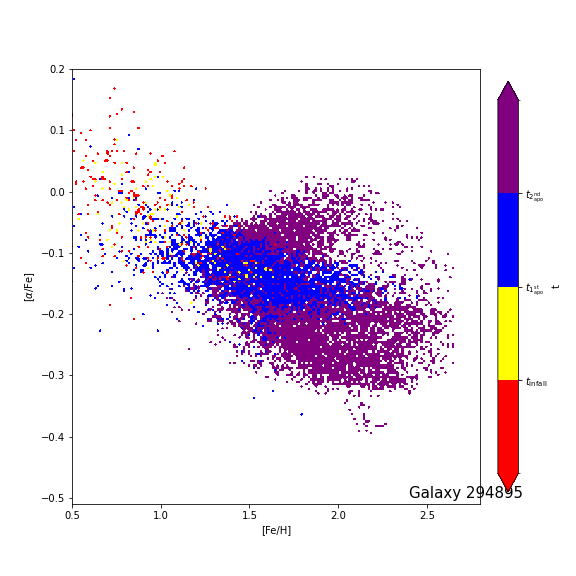

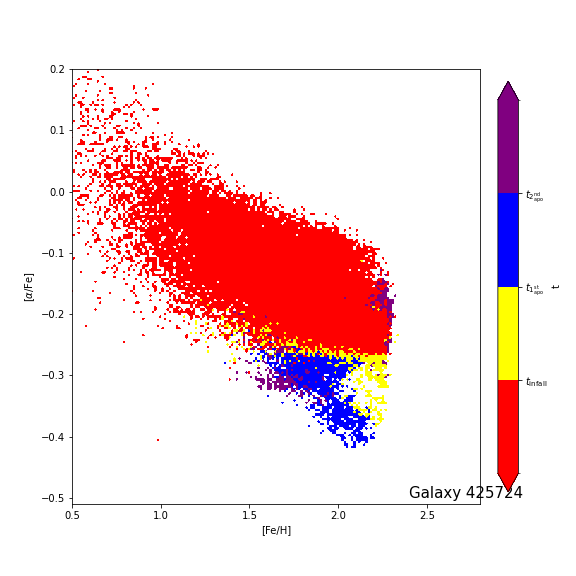

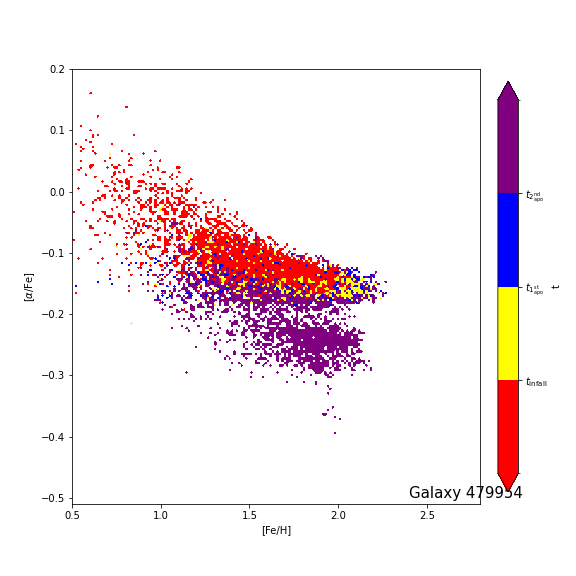

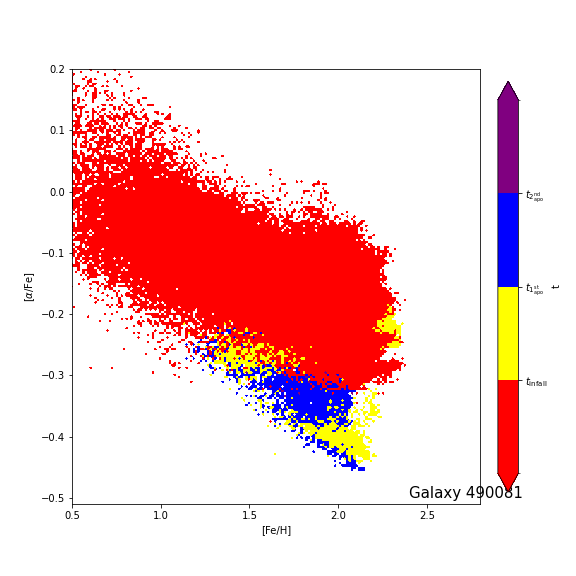

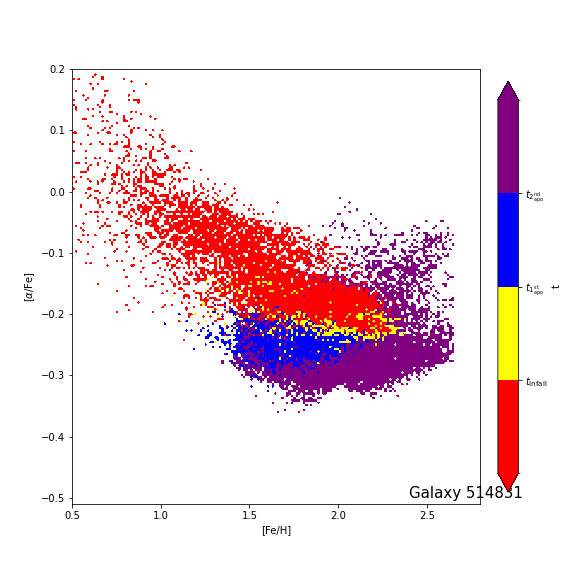

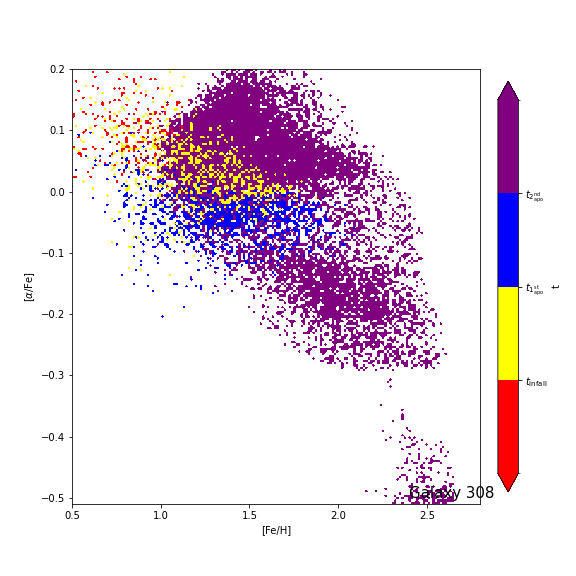

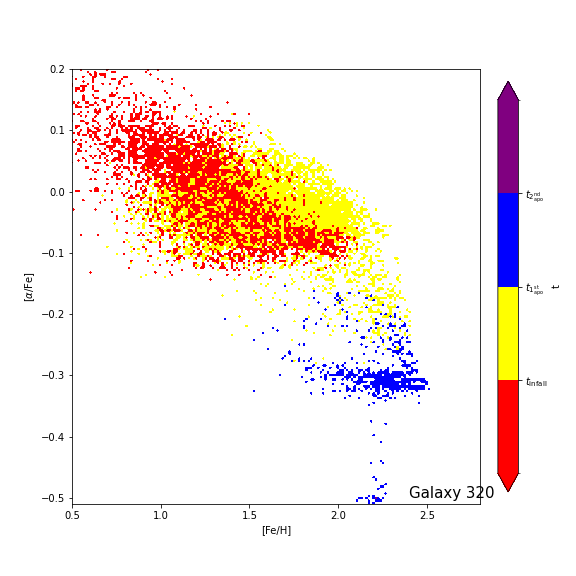

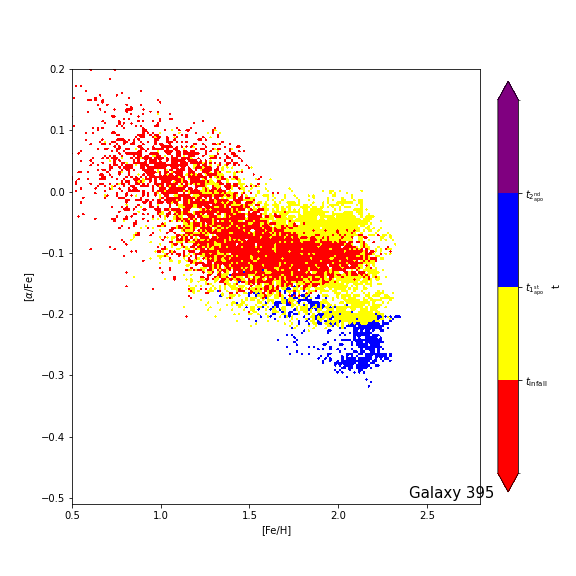

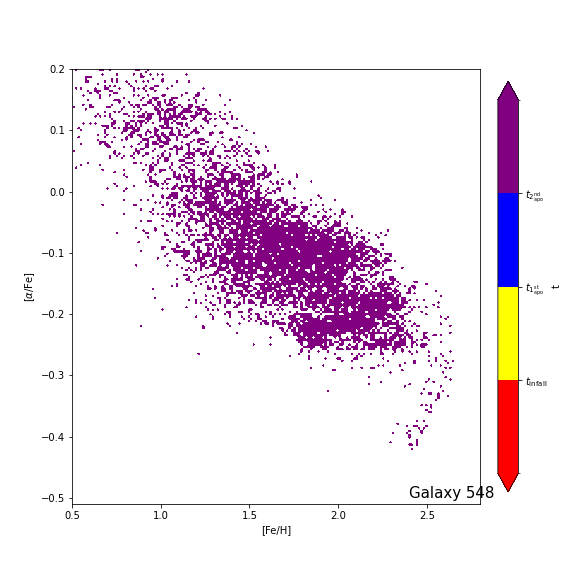

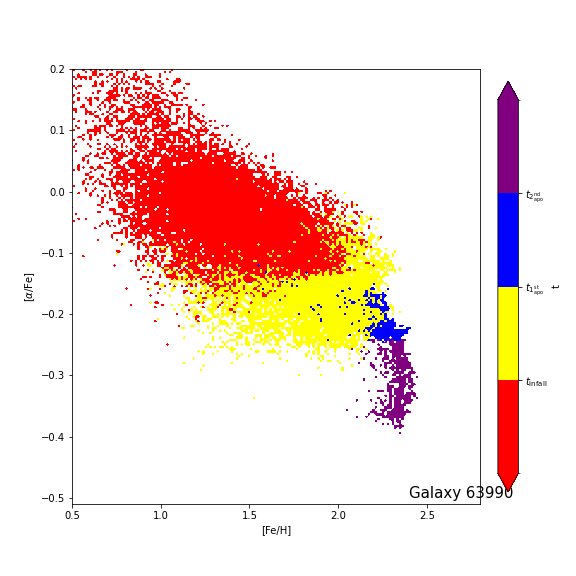

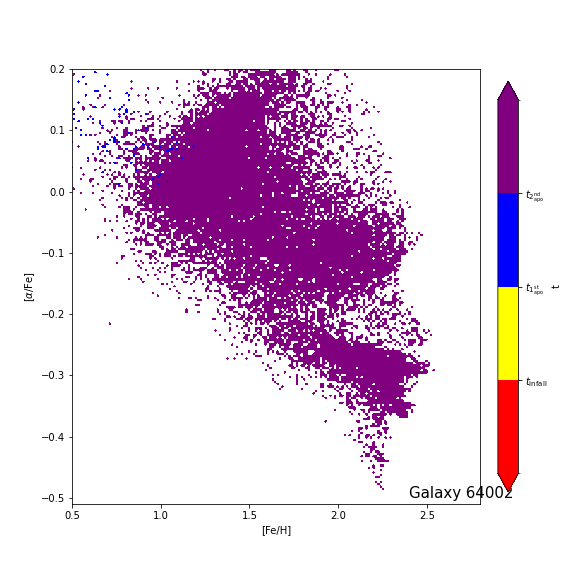

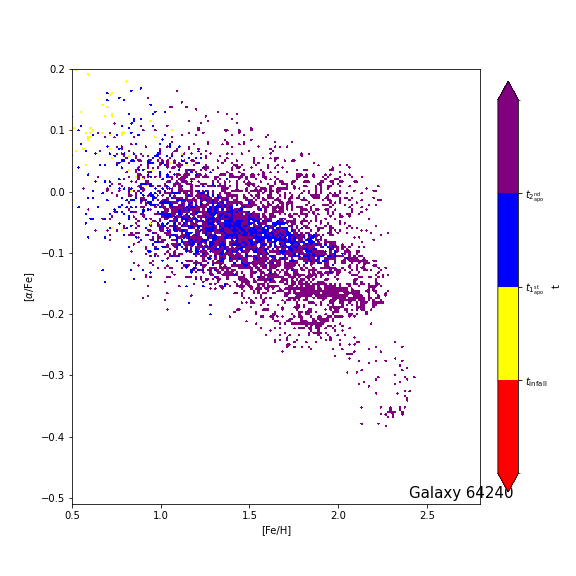

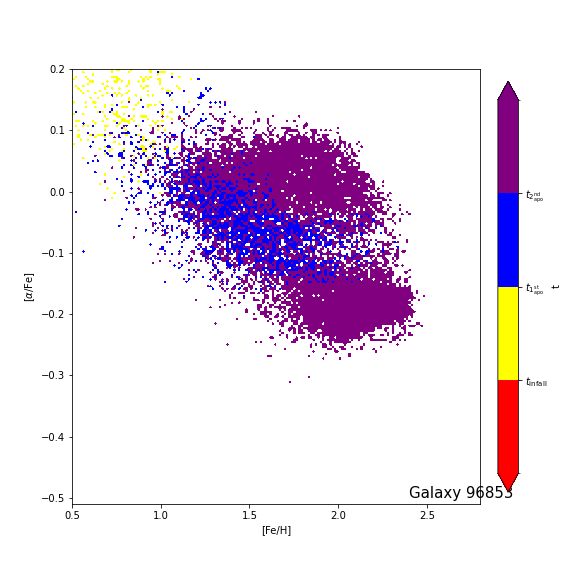

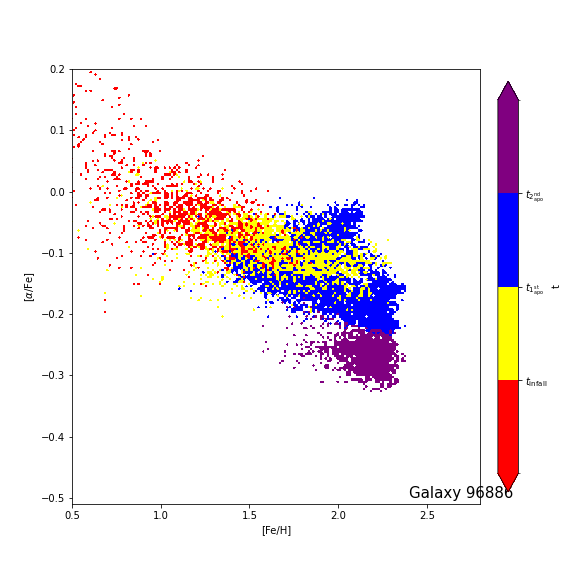

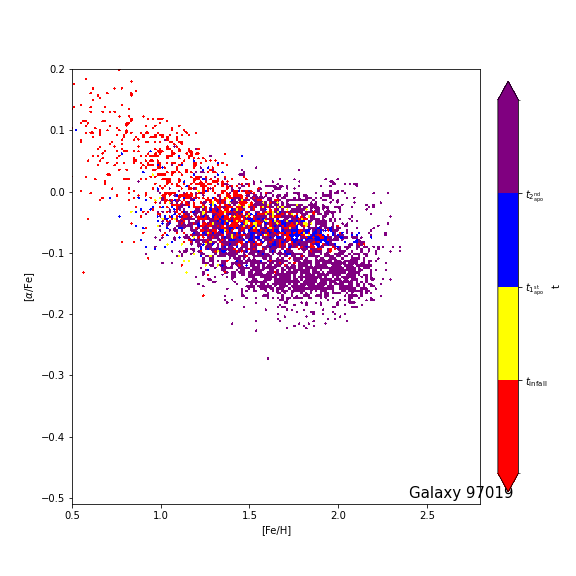

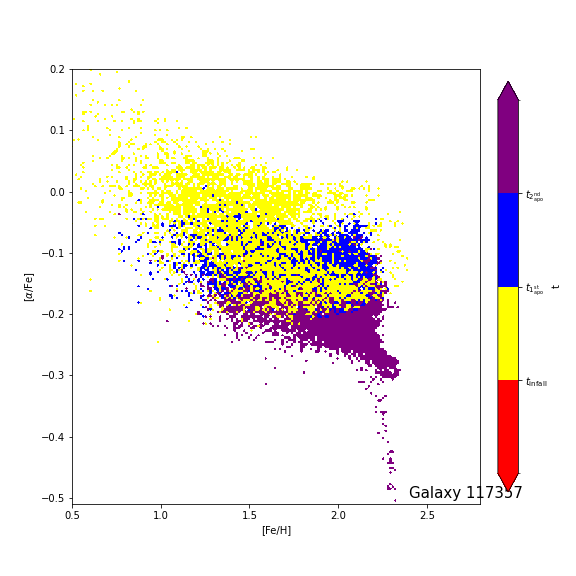

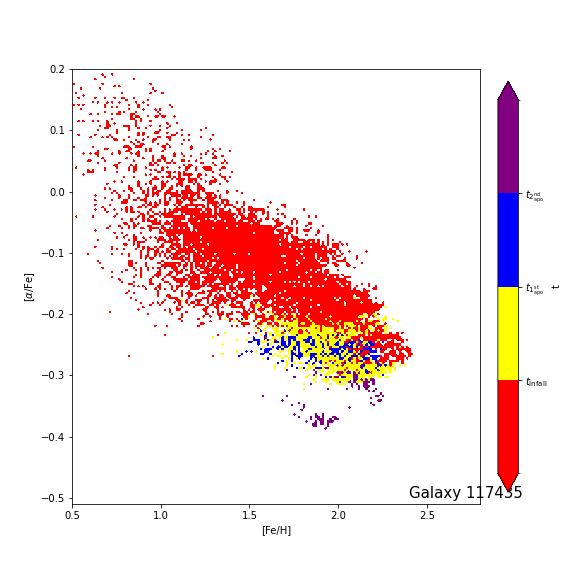

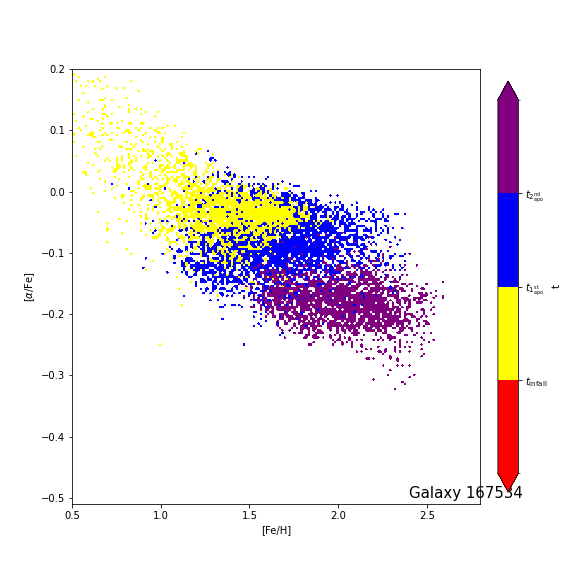

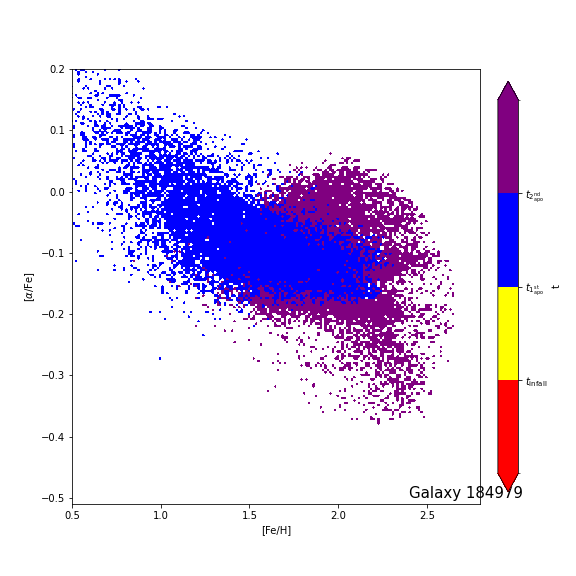

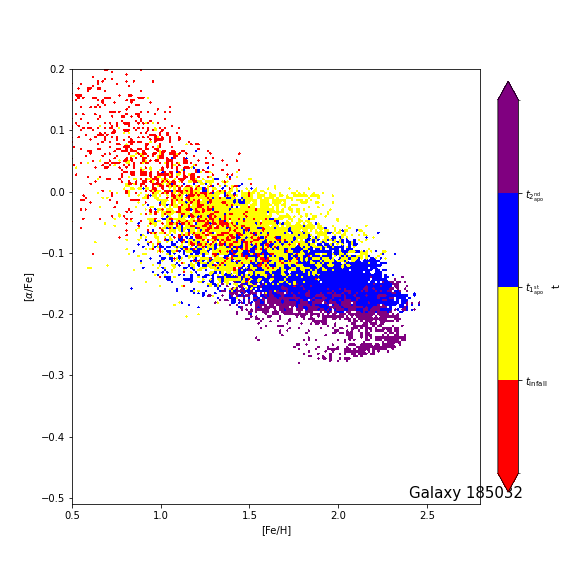

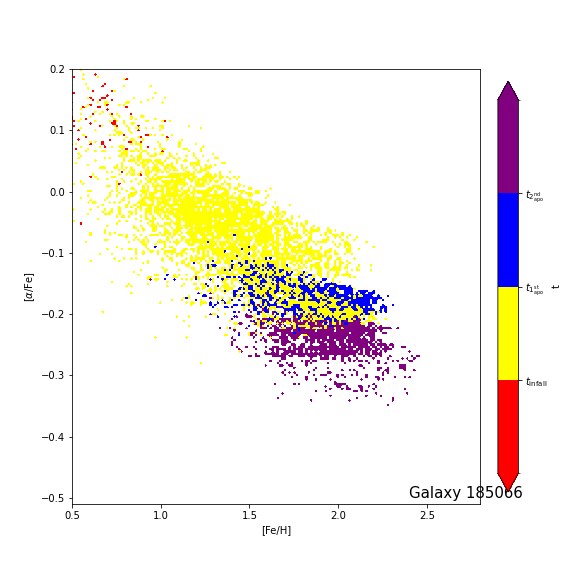

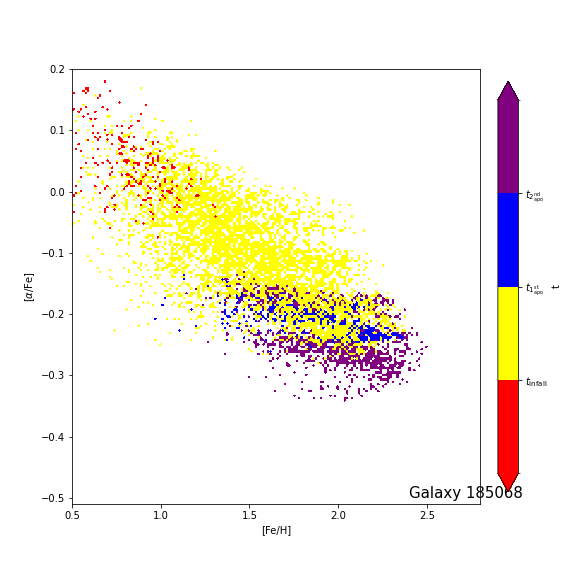

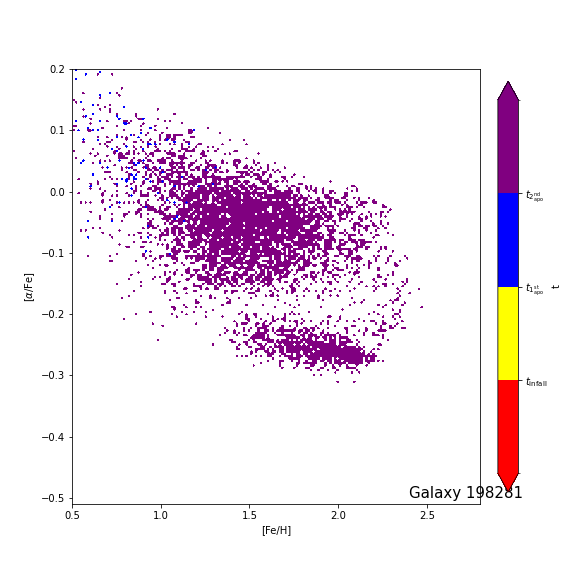

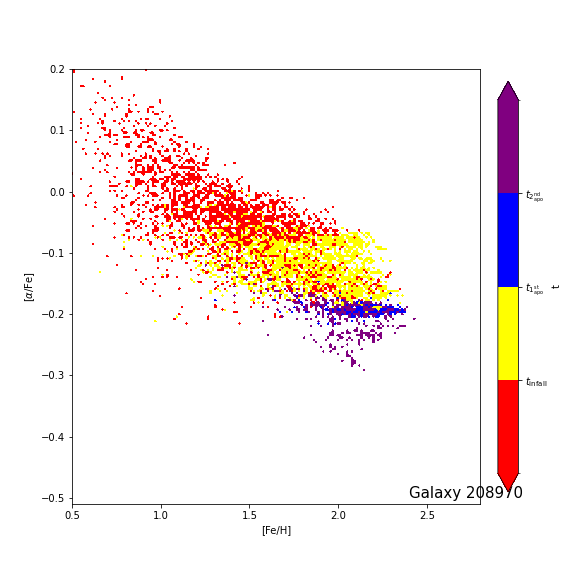

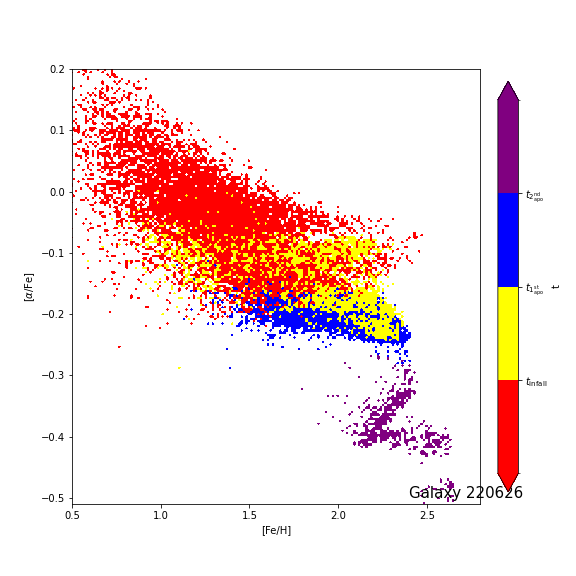

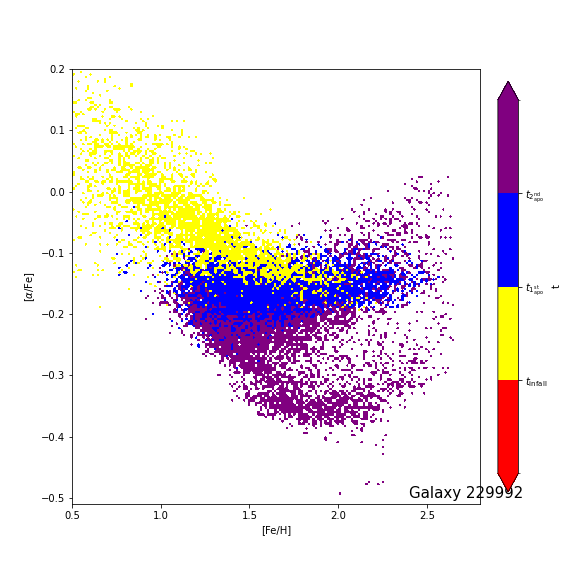

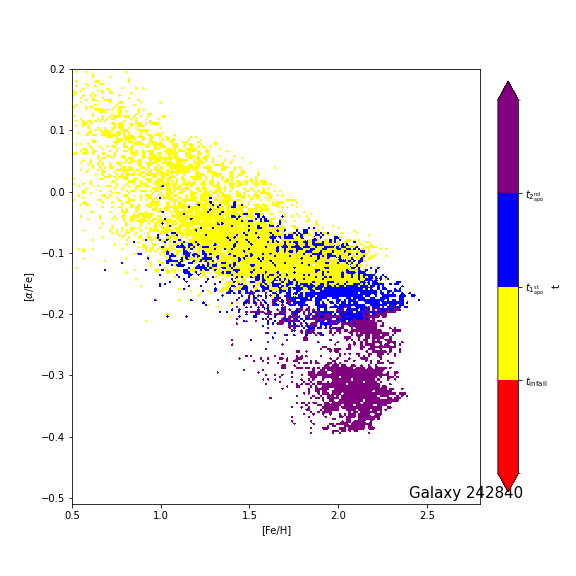

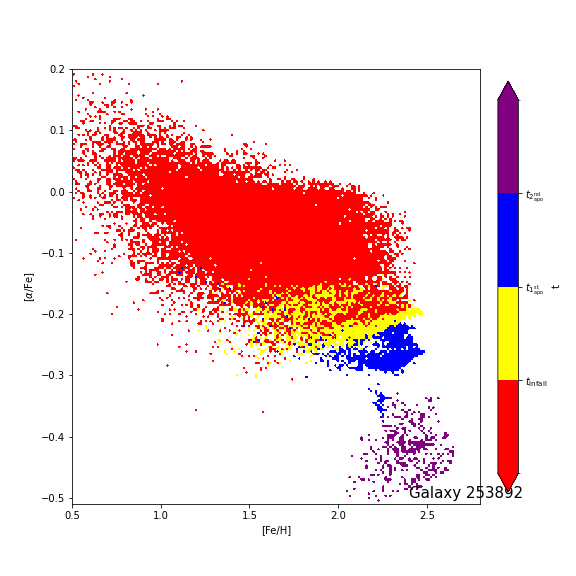

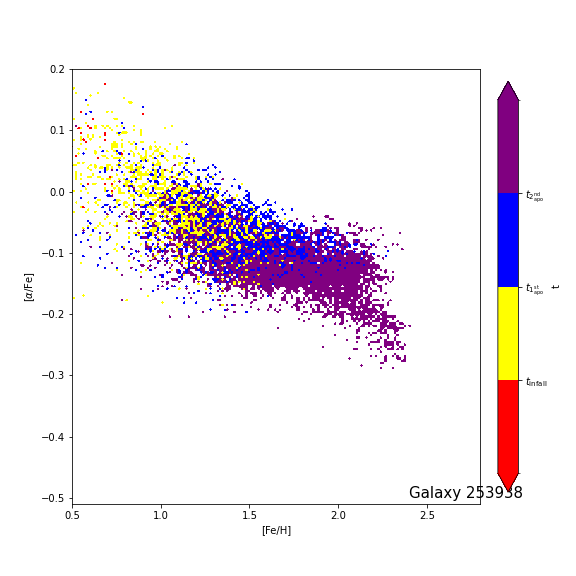

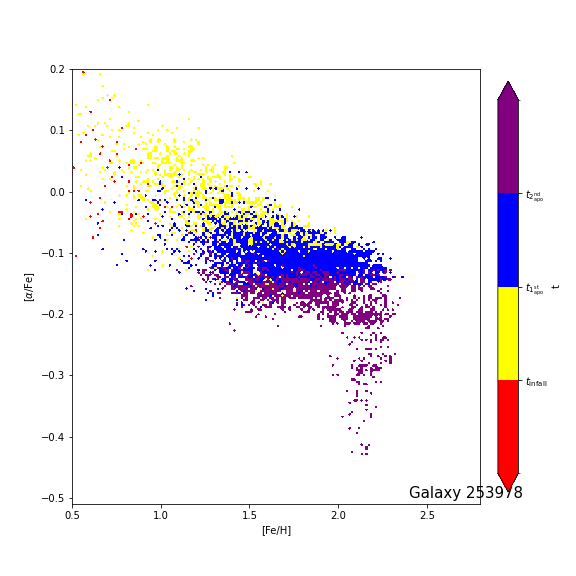

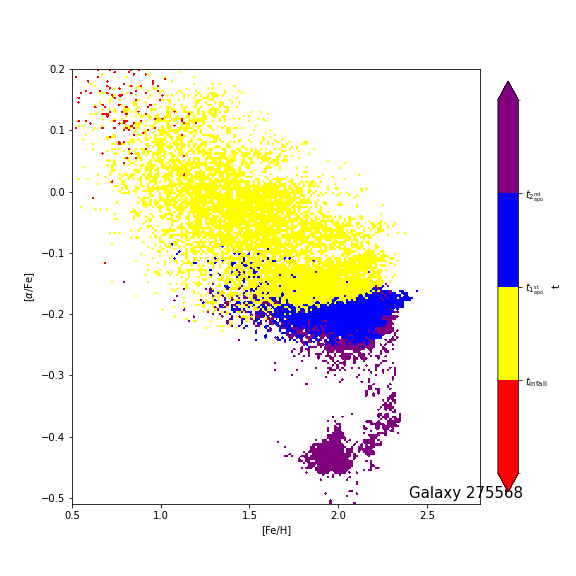

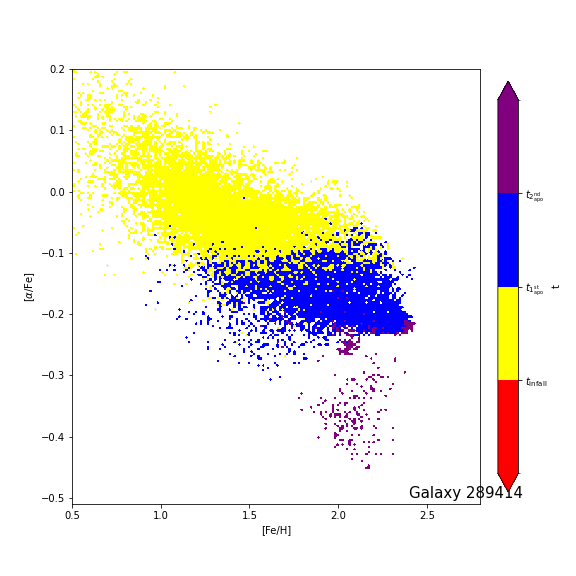

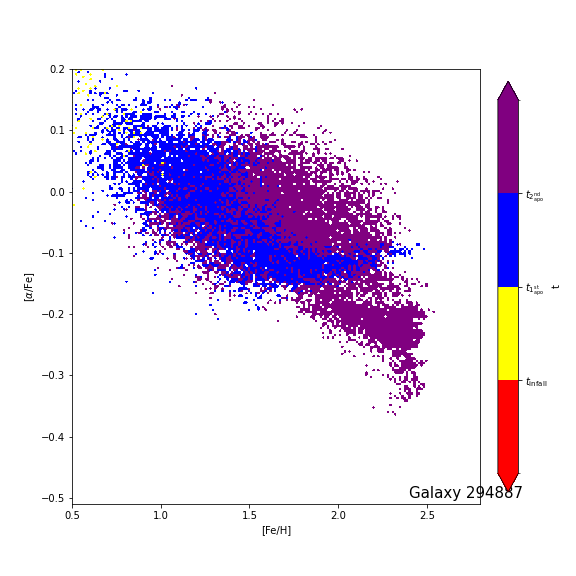

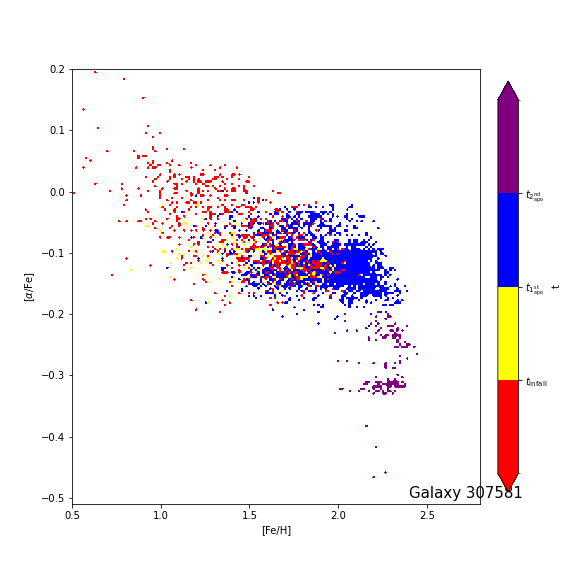

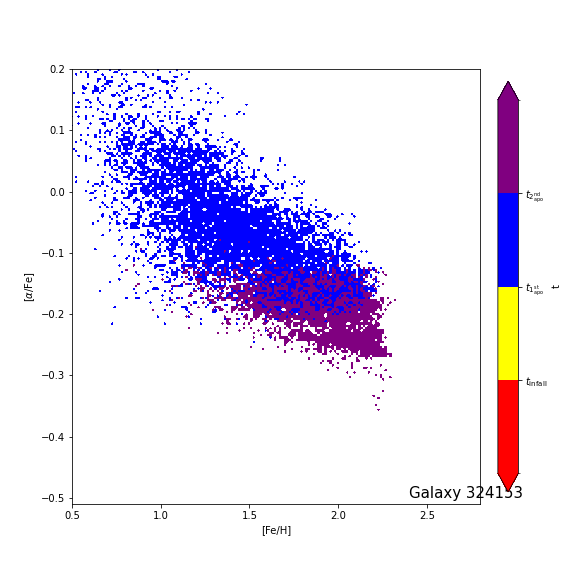

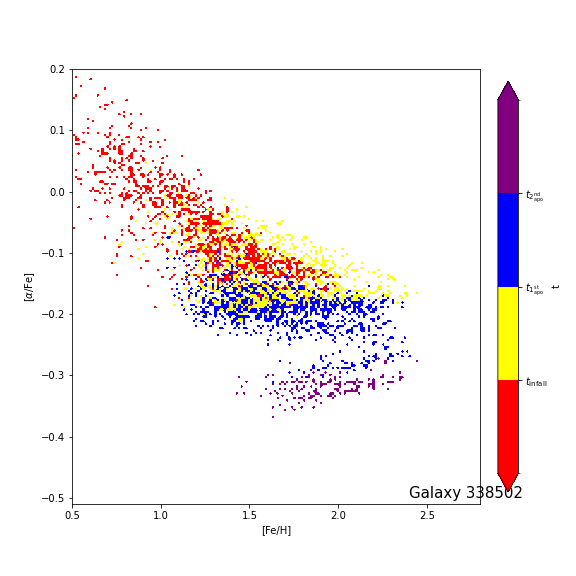

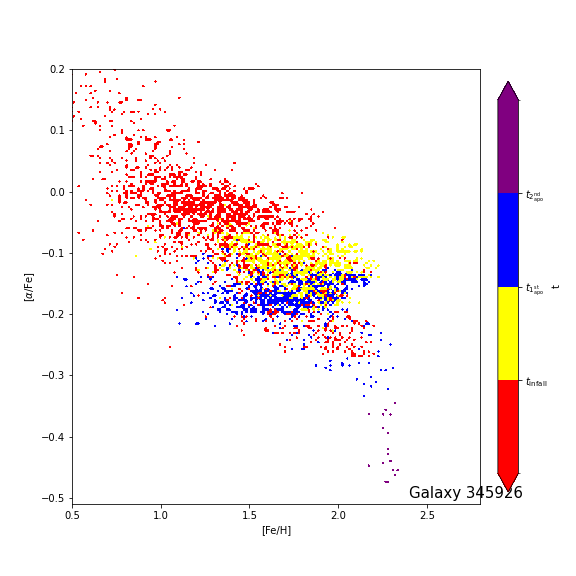

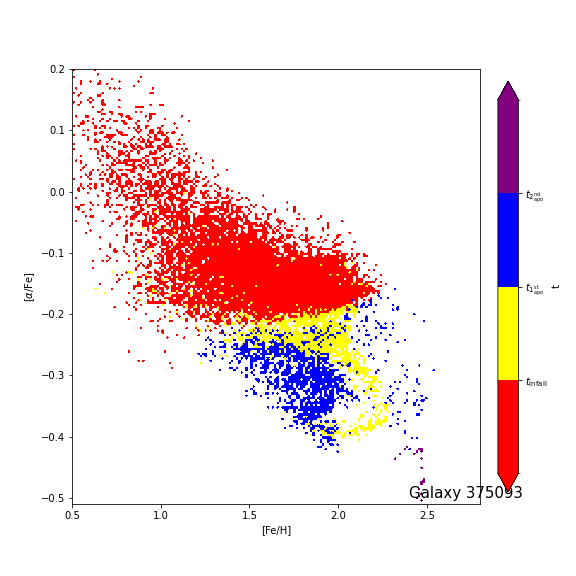

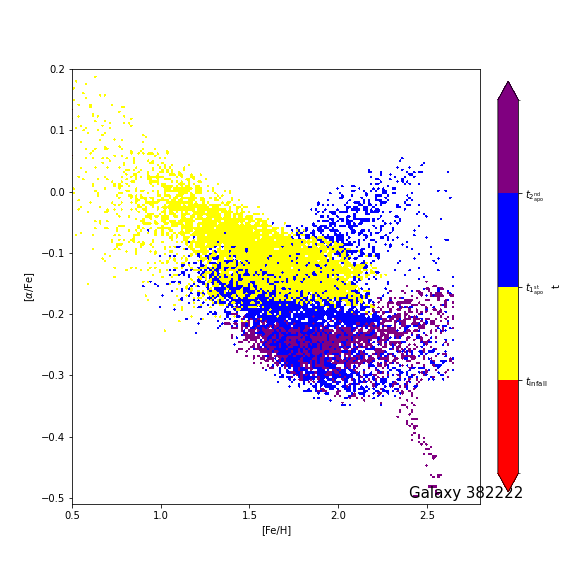

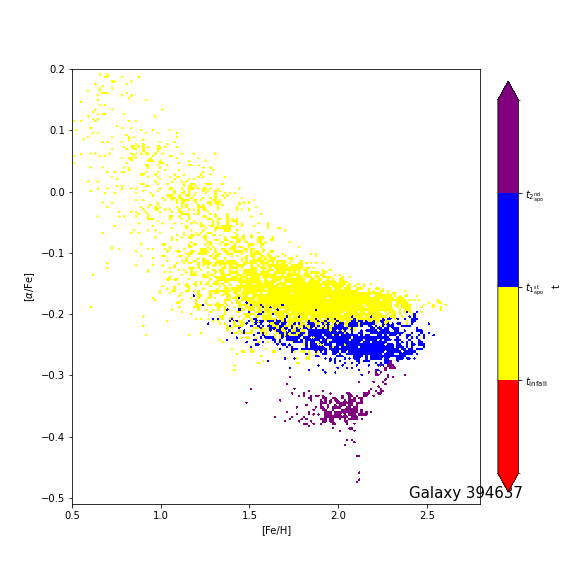

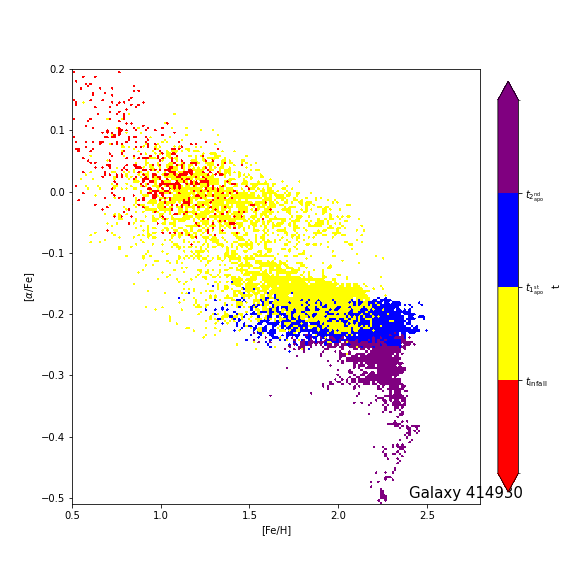

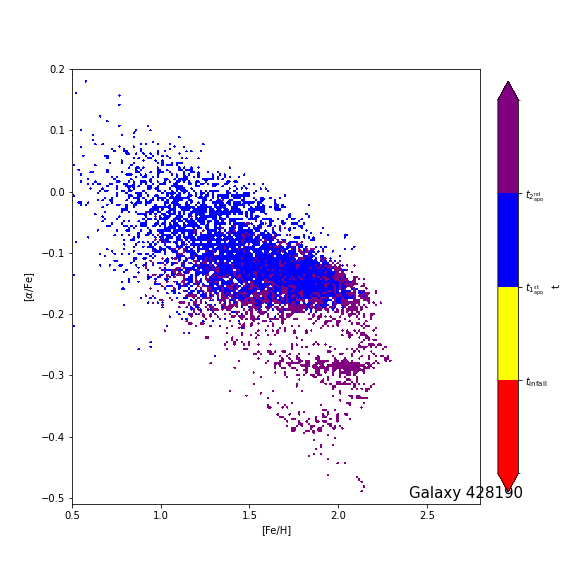

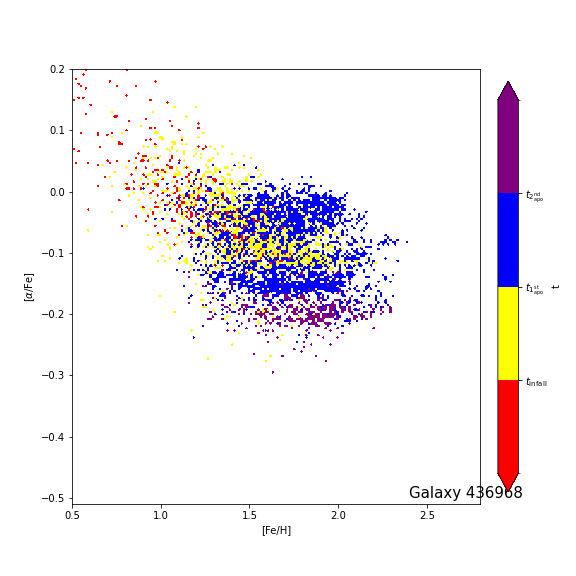

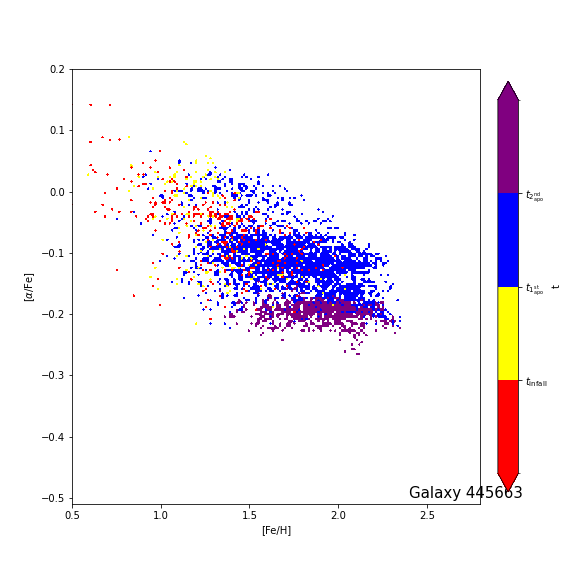

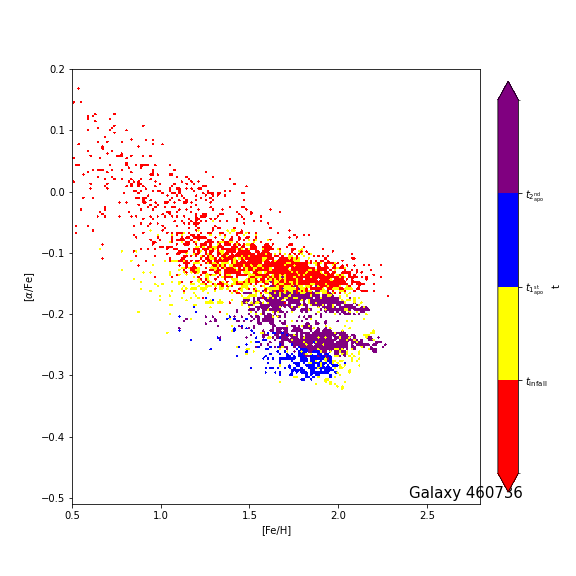

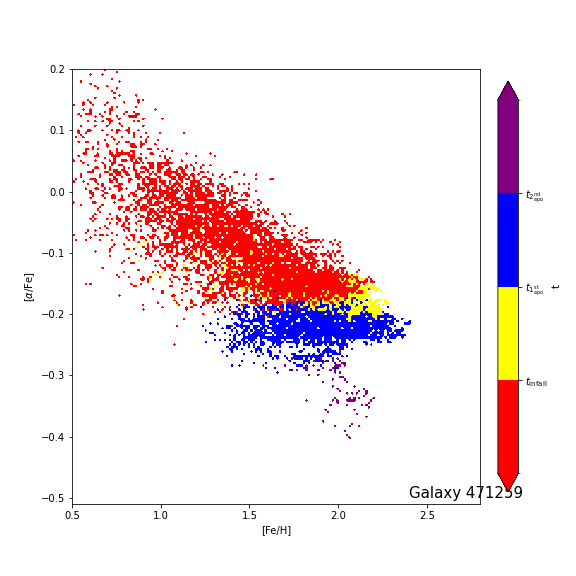

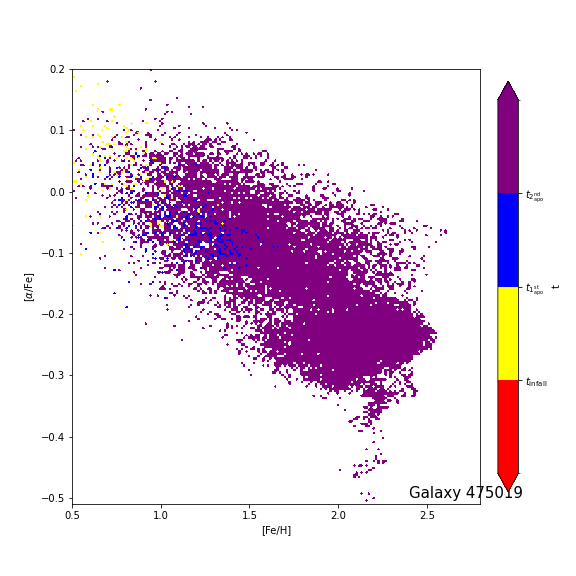

In [3]:
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

# 路径到 HDF5 文件
file_path = '/home/bianyuan/workspace/data/Fingerprint/MRO_finger.hdf5'

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

# filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
# filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') & (np.array(CSSs3['TS_strength'] >= 0.6))
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['BSF_strength'] > 0.6)) & (np.array(CSSs3['TS_strength'] < 0.6))
filter_condition_None = ((np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') | (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')) & (np.array(CSSs3['BSF_strength'] <= 0.6)) & (np.array(CSSs3['TS_strength'] < 0.6))

filtered_ids = np.array(CSSs3['ID'])[filter_condition_TS]

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/Fingerprint/MRI_finger.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/Fingerprint/MRO_finger.hdf5'
}

dex = 0.55

# 显示范围和颜色映射设置
hist_range = [[0.5-dex, 3.2-dex], [-0.51, 0.25]]
extent = [hist_range[0][0], hist_range[0][1], hist_range[1][0], hist_range[1][1]]

# 对于每个HDF5文件
for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        for group_name in tqdm(filtered_ids, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            if group_name_str in hdf_file:
                galaxy_group = hdf_file[group_name_str]
                galaxy_id = group_name_str
                try:
                    alphaFe = galaxy_group['alphaFe'][:]
                    FeH = galaxy_group['FeH'][:]
                    age = galaxy_group['age'][:]
                    pericenters = np.array(galaxy_group['pericenters'])
                    apocenters = np.array(galaxy_group['apocenters'])
                    infalltime = galaxy_group['infalltime'][()]
                    first_apocenter_time = apocenters[0]
                    second_apocenter_time = apocenters[1]

                    # 过滤 NaN 值
                    mask = ~np.isnan(alphaFe) & ~np.isnan(FeH) & ~np.isnan(age)

                    # 计算时间条件
                    time_condition = 13.8 - age[mask]
                    infall_condition = time_condition < infalltime
                    first_apocenter_condition = (time_condition >= infalltime) & (time_condition < first_apocenter_time)
                    second_apocenter_condition = (time_condition >= first_apocenter_time) & (time_condition < second_apocenter_time)
                    beyond_condition = (time_condition >= second_apocenter_time)

                    # 绘制散点图
                    fig, ax = plt.subplots(figsize=(8, 8))

                    for condition, cmap in zip([beyond_condition,second_apocenter_condition,first_apocenter_condition,infall_condition], 
                                            [mpl.colors.ListedColormap(['none','purple']), mpl.colors.ListedColormap(['none','blue']), mpl.colors.ListedColormap(['none','yellow']), mpl.colors.ListedColormap(['none','red'])]):
                            
                        # 根据时间条件过滤数据
                        FeH_cond = FeH[mask][condition]
                        alphaFe_cond = alphaFe[mask][condition]
                        
                        # 统计数据
                        stat, xedge, yedge, binnumber = stats.binned_statistic_2d(FeH_cond, alphaFe_cond, 
                                                                                        alphaFe_cond, statistic='count', bins=200, range=hist_range)
                        data = stat.T
                        data[data == 0] = np.nan  # 假设小于0.5的数据点是"没有数据"的地方
                        data[data > 0] = 1
                        mask1 = np.isnan(data)
                        color_data = np.zeros_like(data)
                        color_data[~mask1] = 1
                        im_time = plt.imshow(color_data, extent=extent, origin='lower', cmap=cmap, aspect='auto')
                    plt.text(2.4, -0.5, f'Galaxy {galaxy_id}', fontsize=15, color='black')

                    # 定义范围
                    plt.xlim(0.5, 3.2)
                    plt.ylim(-0.51, 0.25)

                    # 创建一个颜色映射和范围norm来表示你的颜色
                    cmap = mpl.colors.ListedColormap(['red', 'yellow', 'blue', 'purple'])
                    bounds = [0, 1, 2, 3, 4]  # 你可以根据需要调整这个范围
                    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

                    # 创建一个colorbar
                    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=[1, 2, 3], extend='both', 
                            orientation='vertical', fraction=0.046, pad=0.04)

                    # 设置colorbar的标签，反映在颜色接缝处
                    cb.set_ticklabels([f'$t_{{\mathrm{{infall}}}}$',
                                    f'$t_{{1^{{\mathrm{{st}}}}_{{\mathrm{{apo}}}}}}$',
                                    f'$t_{{2^{{\mathrm{{nd}}}}_{{\mathrm{{apo}}}}}}$'])

                    cb.set_label('t')

                    # 定义范围
                    plt.xlim(0.5, 2.8)
                    plt.ylim(-0.51, 0.2)

                    plt.xlabel('[Fe/H]')
                    plt.ylabel(r'$[\alpha/\mathrm{Fe}]$')

                    # 保存图像
                    plt.savefig(f'/home/bianyuan/workspace/pic/Fingerprint/TS_New/alphaFe_FeH_{galaxy_id}.pdf')
                except:
                    continue
# single

In [22]:
import numpy as np
import illustris_python as il
import h5py

h = 0.6774

def find_local_min_max(distances, Rvir):
    # 找到distances中第一个小于Rvir的索引
    valid_start_index = next((i for i, value in enumerate(distances) if value < Rvir), None)
    
    if valid_start_index is None:
        return []  # 如果没有找到符合条件的索引，则返回空列表
    
    # 查找距离的局部最小点（仅在valid_start_index之后）
    local_min_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] < distances[i - 1] and distances[i] < distances[i + 1]]
    
    local_max_indices = [i for i in range(valid_start_index + 1, len(distances) - 1) 
                         if distances[i] > distances[i - 1] and distances[i] > distances[i + 1]]
    
    return local_min_indices, local_max_indices, valid_start_index

def element_ratios_Dwf(subhalo_id,host_id,snap=99):

    H0 = 67.74
    h = H0/100.
    WM = 0.3089
    WV = 0.6911
    Tyr = 977.8
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV
    n=1000
    galaxy = deIllustrisTNG_galaxy(subhalo_id, deproject=True, align_with='star', radius_align_max=10., radius_align_min=0., centmode='pot', snapshot=snap, basePath=basePath, run=run)
    az = galaxy.s['tform'] #scale factor
    age = 0.

    FeH_solar = 10**-4.5
    alphaFe_solar = (10**-3.57+10**-3.31+10**-4.49+10**-4.4+10**-4.07)/10**-4.5
    # 加载恒星数据
    star = il.snapshot.loadSubhalo(basePath, snap, subhalo_id, 'star', fields=['Coordinates','GFM_Metals','GFM_Metallicity','Masses','SubfindDensity','BirthPos'])

    # 提取化学元素的丰度
    H = star['GFM_Metals'][:,0]
    Fe = star['GFM_Metals'][:,8]  # 铁
    C = star['GFM_Metals'][:,2]   # 碳
    O = star['GFM_Metals'][:,4]   # 氧
    Ne = star['GFM_Metals'][:,5]  # 氖
    Mg = star['GFM_Metals'][:,6]  # 镁
    Si = star['GFM_Metals'][:,7]  # 硅

    Subhalo = il.groupcat.loadSingle(basePath, snap, subhaloID=subhalo_id)
    halo = il.groupcat.loadSingle(basePath, snap, haloID=Subhalo['SubhaloGrNr'])
    Rvir = halo['Group_R_Crit200']

    # 计算 Fe/H 和 (C+O+Ne+Mg+Si)/Fe 的比值
    Fe_H = np.log10((Fe/H)/FeH_solar)
    alpha_Fe = np.log10(((C + O + Ne + Mg + Si) / Fe)/alphaFe_solar)

    for j in range(n):
        a = az*(j+0.5)/n
        adot = (WK+(WM/a)+(WR/(a*a))+(WV*a*a))**0.5
        age = age + adot**(-1)
    zage = az*age/n
    zage_Gyr = (Tyr/H0)*zage #this is calculate age
    zage_LBT = FT(redshift_snapshot(99)) - zage_Gyr

    fields = ['SubfindID','SubhaloGrNr','SubhaloVel','SubhaloMassInHalfRadType','SnapNum','SubhaloStarMetallicity',
        'SubhaloSFRinHalfRad','SubhaloHalfmassRadType',
        'SubhaloStarMetallicityHalfRad','GroupFirstSub',
        'SubhaloMassType','SubhaloSFR','SubhaloHalfmassRadType',
        'SubhaloStarMetallicity','SubhaloWindMass','SubhaloSpin',
        'SubhaloMass','SubhaloIDRaw','SubhaloPos','SubhaloStarMetalFractions']
    sat_idx_map = {}
    velocity = []
    distances = []
    Snap = []
    tree = il.sublink.loadTree(basePath,99,subhalo_id,fields=fields,onlyMPB=True)
    host_tree = il.sublink.loadTree(basePath,99,host_id,fields=fields,onlyMPB=True)
    haloID = tree['SubhaloGrNr'][0]
    halo = il.groupcat.loadSingle(basePath, 99, haloID=haloID)

    sat_snap = tree['SnapNum']
    cen_snap = host_tree['SnapNum']
    Rvir = halo['Group_R_Crit200'] / h

    for ii, snap_num in enumerate(cen_snap):
        sat_idx = np.where(sat_snap == snap_num)[0]
        if len(sat_idx) > 0:
            sat_idx_map[ii] = sat_idx[0]
    for cen_idx, sat_idx in sat_idx_map.items():
        cen_pos = host_tree['SubhaloPos'][cen_idx]
        cen_vel = host_tree['SubhaloVel'][cen_idx]
        cen_snap = host_tree['SnapNum'][cen_idx]
        sat_pos = tree['SubhaloPos'][sat_idx]
        sat_vel = tree['SubhaloVel'][sat_idx]
        sat_snap = tree['SnapNum'][sat_idx]

        distances.append(np.sqrt(np.sum((sat_pos - cen_pos)**2)))
        Snap.append(sat_snap)

    distances = distances[::-1]
    Snap = Snap[::-1]

    print(distances)
    print(Rvir)    
    
    # 找到近心点和远心点
    local_min, local_max, infall_index = find_local_min_max(np.array(distances), Rvir)

    if infall_index is not None:
        infall_time = FT(redshift_snapshot(Snap[np.array(infall_index)]))
    else:
        infall_time = np.nan

    if (local_min is not None) & (len(local_min) > 0):
        pericenters_time = FT(redshift_snapshot(Snap[np.array(local_min)]))
    else:
        pericenters_time = np.nan

    if (local_max is not None) & (len(local_max) > 0):
        apocenters_time = FT(redshift_snapshot(Snap[np.array(local_max)]))
    else:
        apocenters_time = np.nan

    galaxydic={}
    galaxydic['alphaFe']=alpha_Fe
    galaxydic['FeH']=Fe_H
    galaxydic['age']=zage_LBT
    galaxydic['infalltime']=infall_time
    galaxydic['pericenters'] = pericenters_time
    galaxydic['apocenters'] = apocenters_time
    return galaxydic

In [25]:
import pandas as pd

CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
ND = sns.load_dataset('Normal_Dwarf_1',data_home='/home/bianyuan/workspace/data',cache=True)

j = np.array(ND['ID'])[2]
k = np.array(ND['HostID'])[2]

print(j,k)

with h5py.File('/home/bianyuan/workspace/data/Fingerprint/ND_finger.hdf5', 'w') as f:
    grp = f.create_group(str(j))
    galaxyd = element_ratios_Dwf(j,k)
    dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
    dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
    dset = grp.create_dataset('age', data=galaxyd['age'])
    dset = grp.create_dataset('infalltime', data=galaxyd['infalltime'])
    dset = grp.create_dataset('pericenters', data=galaxyd['pericenters'])
    dset = grp.create_dataset('apocenters', data=galaxyd['apocenters'])
    f.close()

20 0
Header: {'BoxSize': 35000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 1, 'Ngroups_Total': 10247012, 'Nids_ThisFile': 13513936, 'Nids_Total': 9471772986, 'Nsubgroups_ThisFile': 63864, 'Nsubgroups_Total': 5688113, 'NumFiles': 680, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
dict_keys(['count', 'Coordinates', 'Velocities', 'Masses', 'ParticleIDs', 'GFM_StellarFormationTime'])
dict_keys(['count', 'Coordinates', 'Velocities', 'Masses', 'ParticleIDs'])
dict_keys(['count', 'Coordinates', 'Velocities', 'ParticleIDs'])
Main galaxy: 318432 35068 294095
Keys: ['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass']
Bins: 684 Maximum radius used: 68.47182859365103
Effective radius: 4.004200502552692 kpc; 0.503863996848478
rvir,mvir,vvir 113.26816699970115 155278954774.61084 76.7958172257974
radius_align:

In [26]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
ND = sns.load_dataset('Normal_Dwarf_1',data_home='/home/bianyuan/workspace/data',cache=True)

with h5py.File('/home/bianyuan/workspace/data/Fingerprint/ND_finger.hdf5', 'w') as f:
    with tqdm(total=len(np.array(ND['ID']))) as pbar:
        for (j,k) in zip(np.array(ND['ID']),np.array(ND['HostID'])):
            with open('/dev/null', 'w') as null_file:
                sys.stdout = null_file
                grp = f.create_group(str(j))
                try:
                    galaxyd = element_ratios_Dwf(j,k)
                    dset = grp.create_dataset('alphaFe', data=galaxyd['alphaFe'])
                    dset = grp.create_dataset('FeH', data=galaxyd['FeH'])
                    dset = grp.create_dataset('age', data=galaxyd['age'])
                    dset = grp.create_dataset('infalltime', data=galaxyd['infalltime'])
                    dset = grp.create_dataset('pericenters', data=galaxyd['pericenters'])
                    dset = grp.create_dataset('apocenters', data=galaxyd['apocenters'])
                except:
                    continue
                sys.stdout = sys.__stdout__
            pbar.update(1)
    f.close()

  0%|          | 0/5184 [00:00<?, ?it/s]

/home/bianyuan/.local/lib/python3.10/site-packages/pynbody/array.py:470: RuntimeWarning: invalid value encountered in power
  r = np.asarray(np.power(self.view(np.ndarray), numerical_x)).view(SimArray)
  0%|          | 3/5184 [02:04<72:43:27, 50.53s/it]

In [3]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

file_paths = {
    'MRI_path': '/home/bianyuan/workspace/data/Fingerprint/MRI_finger.hdf5',
    'MRO_path': '/home/bianyuan/workspace/data/Fingerprint/MRO_finger.hdf5'
}

filter_condition_TS = np.array(CSSs3['Form_Type']) == 'Tidal Stripping'
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation')
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

filtered_ids_BSF = np.array(CSSs3['ID'])[filter_condition_BSF]
filtered_ids_TS = np.array(CSSs3['ID'])[filter_condition_TS]

# filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') & (np.array(CSSs3['TS_strength'] >= 0.6))
# filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['BSF_strength'] > 0.6)) & (np.array(CSSs3['TS_strength'] < 0.6))
# filter_condition_None = ((np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') | (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')) & (np.array(CSSs3['BSF_strength'] <= 0.6)) & (np.array(CSSs3['TS_strength'] < 0.6))
# filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids_BSF = np.concatenate((np.array(CSSs3['ID'])[filter_condition_BSF],np.array([275692,436946])),axis=0)
# filtered_ids_TS = np.concatenate((np.array(CSSs3['ID'])[filter_condition_TS],np.array([220728,410046])),axis=0)

pericenters_TS = []
pericenters_BSF = []

for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        for group_name in tqdm(filtered_ids_BSF, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            try:
                if group_name_str in hdf_file:
                    group = hdf_file[group_name_str]
                    pericenters = group['pericenters'][:]
                    apocenters = group['apocenters'][:]
                    if group_name_str in ['63931','63950']:
                        first_apocenter_time = pericenters[2]
                    else:
                        first_apocenter_time = pericenters[0]
                    pericenters_BSF.append(first_apocenter_time)
            except:
                continue

for model_name, file_path in file_paths.items():
    with h5py.File(file_path, 'r') as hdf_file:
        for group_name in tqdm(filtered_ids_TS, desc=f"Processing {model_name}"):
            group_name_str = str(group_name)
            try:
                if group_name_str in hdf_file:
                    group = hdf_file[group_name_str]
                    pericenters = np.array(group['pericenters'])
                    apocenters = np.array(group['apocenters'])
                    if group_name_str in ['548', '229996', '275568', '460736']:
                        first_apocenter_time = pericenters[3]
                    elif group_name_str in ['308', '96853', '117357','198281','253938','410046']:
                        first_apocenter_time = pericenters[2]
                    elif group_name_str in ['64002', '64240', '97019','185032','185068','289414','294895','428190','436968','438152','445663']:
                        first_apocenter_time = pericenters[1]
                    else:
                        first_apocenter_time = pericenters[0]
                    pericenters_TS.append(first_apocenter_time)
            except:
                continue

Processing MRO_path: 100%|██████████| 54/54 [00:00<00:00, 1743.52it/s]


In [15]:
print(pericenters_BSF)

[9.224618676747614, 8.119286507530553, 7.9221537705970855, 9.064728126452174, 8.119286507530553, 9.224618676747614, 9.224618676747614, 9.064728126452174, 9.818228665816386, 9.818228665816386, 8.119286507530553, 8.119286507530553, 9.064728126452174, 8.119286507530553, 9.388711810462867, 9.224618676747614, 7.794723884310293, 9.818228665816386, 7.9221537705970855, 8.119286507530553, 7.794723884310293, 9.224618676747614, 9.224618676747614, 8.119286507530553, 9.818228665816386, 8.90890982886588, 8.119286507530553, 9.730050561809449, 7.794723884310293, 9.224618676747614, 7.609327953982905, 7.9221537705970855, 7.609327953982905, 9.388711810462867, 8.90890982886588, 7.9221537705970855, 8.90890982886588, 9.224618676747614, 9.064728126452174, 8.119286507530553, 8.90890982886588, 7.9221537705970855, 9.224618676747614, 8.393835920130568, 8.90890982886588, 8.393835920130568, 8.393835920130568, 9.224618676747614, 7.31491118858098, 9.557142502477856, 6.6756365542186735, 7.794723884310293, 10.87001597

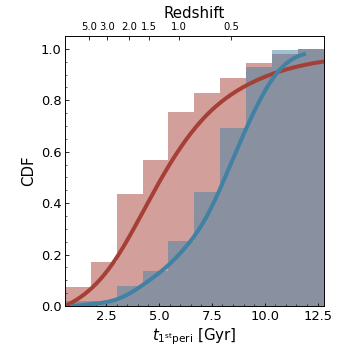

In [6]:
import seaborn as sns
import scipy.optimize as optimize

# 定义时间转红移的函数
def ZT(time, h0=0.6774, OmegaM=0.3089, OmegaL=0.6911, z1=0, z2=1000):
    """
    Find the redshift corresponding to a given time.
    
    Parameters:
    - time: The time in Gyr.
    - h0, OmegaM, OmegaL: Cosmological parameters.
    - z1, z2: The search interval for the redshift.
    
    Returns:
    - The redshift corresponding to the given time.
    """
    # 定义一个辅助函数，计算给定红移下的时间与目标时间的差
    def time_diff(z):
        return FT(z, h0, OmegaM, OmegaL) - time
    
    # 使用brentq方法寻找使time_diff函数为0的红移值
    redshift = optimize.brentq(time_diff, z1, z2)
    
    return redshift

num_bins = 10
bin_range = (min(min(pericenters_BSF), min(pericenters_TS)), max(max(pericenters_BSF), max(pericenters_TS)))

grp = (65/255,130/255,164/255,0.8)
cl = (166/255,64/255,54/255,0.8)

plt.figure(figsize=(5,5))
plt.subplots_adjust(left=0.18, bottom=0.15, right=0.90, top=0.90)
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内

# Plot histogram with KDE for pericenters_TS
sns.histplot(pericenters_TS, kde=True, color=cl, edgecolor='none', stat='density', label='Tidal Stripping', bins=num_bins, binrange=bin_range, line_kws={'linewidth': 4}, cumulative=True)

# Plot histogram with KDE for pericenters_BSF
sns.histplot(pericenters_BSF, kde=True, color=grp, edgecolor='none', stat='density', label='Bursty Star Formation', bins=num_bins, binrange=bin_range, line_kws={'linewidth': 4}, cumulative=True)

# 创建新的顶部x轴
ax1 = plt.gca()  # 获取当前的Axes对象
ax2 = ax1.twiny()  # 创建一个新的Axes对象，共享y轴

# 设置新轴的刻度位置和刻度标签
new_tick_locations = np.array([1.177, 2.145, 3.285, 4.293, 5.878, 8.587])
new_tick_labels = ["5.0", "3.0", "2.0", "1.5", "1.0", "0.5"]  # 对应的红移值

# 设置新轴的刻度和标签
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(new_tick_labels)
ax2.set_xlim(ax1.get_xlim())  # 确保新轴的x范围与原轴相同
ax2.tick_params(axis='x', labelcolor='black', labelsize=10)
ax2.set_xlabel('Redshift', fontsize=15)  # 为新轴设置标签

# Set labels and legend
ax1.set_xlabel('$t_{{1^{{\mathrm{{st}}}}{{\mathrm{{peri}}}}}}$ [Gyr]', fontsize=15)
ax1.set_ylabel('CDF', fontsize=15)
ax1.minorticks_on()
ax1.tick_params(axis='y', labelcolor='black', labelsize=13)
ax1.tick_params(axis='x', labelcolor='black', labelsize=13)
# plt.tick_params(axis='x', which='both', labelsize=10)
# plt.tick_params(axis='y', which='both', labelsize=10)
ax1.set_xlim(min(min(pericenters_BSF), min(pericenters_TS)), max(max(pericenters_BSF), max(pericenters_TS)))
# ax1.legend(fontsize=10)
plt.savefig('/home/bianyuan/workspace/pic/pericenters.pdf')

In [ ]:
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

grp = (65/255,130/255,164/255,0.8)
cl = (166/255,64/255,54/255,0.8)

CSSs3 = sns.load_dataset('CSSs3', data_home='/home/tnguser/data', cache=True)
filter_condition_TS = (np.array(CSSs3['Form_Type']) == 'Tidal Stripping') & (np.array(CSSs3['TS_strength'] >= 0.6))
filter_condition_BSF = (np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') & (np.array(CSSs3['BSF_strength'] > 0.6)) & (np.array(CSSs3['TS_strength'] < 0.6))
filter_condition_None = ((np.array(CSSs3['Form_Type']) == 'Bursty Star Formation') | (np.array(CSSs3['Form_Type']) == 'Tidal Stripping')) & (np.array(CSSs3['BSF_strength'] <= 0.6)) & (np.array(CSSs3['TS_strength'] < 0.6))
filter_condition_TSBSF = (np.array(CSSs3['Form_Type']) == 'TS+BSF')

# filtered_ids_BSF = np.array(CSSs3['ID'])[filter_condition_BSF]
# filtered_ids_TS = np.array(CSSs3['ID'])[filter_condition_TS]

BSF_strength_None = np.array(CSSs3['BSF_strength'])[(filter_condition_None)]
TS_strength_None = np.array(CSSs3['TS_strength'])[(filter_condition_None)]
Re_dec_None = np.array(CSSs3['Re_dec'])[(filter_condition_None)]

BSF_strength_TS = np.array(CSSs3['BSF_strength'])[(filter_condition_TS)]
TS_strength_TS = np.array(CSSs3['TS_strength'])[(filter_condition_TS)]
Re_dec_TS = np.array(CSSs3['Re_dec'])[(filter_condition_TS)]
BSF_strength_BSF = np.concatenate((np.array(CSSs3['BSF_strength'])[(filter_condition_BSF)], 
                                  np.array(CSSs3['BSF_strength'])[np.array(CSSs3['ID']) == 436946], 
                                  np.array(CSSs3['BSF_strength'])[np.array(CSSs3['ID']) == 275692]), axis=0)
TS_strength_BSF = np.concatenate((np.array(CSSs3['TS_strength'])[(filter_condition_BSF)], 
                                  np.array(CSSs3['TS_strength'])[np.array(CSSs3['ID']) == 436946], 
                                  np.array(CSSs3['TS_strength'])[np.array(CSSs3['ID']) == 275692]), axis=0)
Re_dec_BSF = np.concatenate((np.array(CSSs3['Re_dec'])[(filter_condition_BSF)], 
                                  np.array(CSSs3['Re_dec'])[np.array(CSSs3['ID']) == 436946], 
                                  np.array(CSSs3['Re_dec'])[np.array(CSSs3['ID']) == 275692]), axis=0)

highlight_ids_BSF = np.array(CSSs3['ID'])[(filter_condition_BSF) & (np.array(CSSs3['TS_strength']) > 0.6)]

highlight_ids_TS = np.array(CSSs3['ID'])[(filter_condition_TS) & (np.array(CSSs3['TS_strength']) < 0.6)]

highlight_ids_bursty_TS = np.array(CSSs3['ID'])[(filter_condition_TS) & (np.array(CSSs3['BSF_strength']) > 0.8)]

# highlight_ids = np.concatenate((highlight_ids_BSF, highlight_ids_TS, highlight_ids_bursty_TS), axis=0)

highlight_ids = np.array([386288, 414930, 430876, 436946, 439101, 448833, 475019])
                                                
# highlight_ids = highlight_ids_TS

CSSs3['highlight1'] = CSSs3['ID'].isin(highlight_ids)

plt.figure(figsize=(10,8),dpi=600)

plt.tick_params(axis='x', which='both', labelsize=20)
plt.tick_params(axis='y', which='both', labelsize=20)
plt.tick_params(axis='both', which='minor', direction='in', labelbottom=False, labelleft=False)

# plt.scatter(np.concatenate((BSF_strength_BSF, BSF_strength_TS), axis=0), np.concatenate((TS_strength_BSF, TS_strength_TS), axis=0), c=np.log10(np.concatenate((Rec_BSF, Rec_TS), axis=0)), cmap='viridis', marker='v', edgecolor='none', label='Tidal Stripping')

all_BSF_strength = np.concatenate((BSF_strength_TS, BSF_strength_BSF, BSF_strength_None), axis=0)
all_TS_strength = np.concatenate((TS_strength_TS, TS_strength_BSF, TS_strength_None), axis=0)
all_Re_dec_log = np.log10(np.concatenate((Re_dec_TS, Re_dec_BSF, Re_dec_None), axis=0))

# hb = plt.hexbin(all_BSF_strength, all_TS_strength, C=all_Rec_log, gridsize=5, cmap='viridis', reduce_C_function=np.mean)

# 创建网格
xi = np.linspace(-0.02, 1.02, 1000)
yi = np.linspace(-0.02, 1.02, 1000)
xi, yi = np.meshgrid(xi, yi)

# 在网格上插值
zi = griddata((all_BSF_strength, all_TS_strength), all_Re_dec_log, (xi, yi), method='nearest')

# norm = mcolors.TwoSlopeNorm(vmin=np.percentile(all_Re_dec_log,5), vcenter=1, vmax=np.percentile(all_Re_dec_log,95))
norm = mcolors.Normalize(vmin=np.percentile(all_Re_dec_log,5), vmax=np.percentile(all_Re_dec_log,95))

# plt.pcolormesh(xi, yi, zi, cmap='viridis')
plt.imshow(zi, extent=[-0.02, 1.02, -0.02, 1.02], origin='lower', cmap='binary', aspect='auto', norm=norm)

# bg_data = np.outer(np.ones(100), np.linspace(all_Rec_log.min(), all_Rec_log.max(), 100))

# # 显示背景色块图
# cmap = plt.get_cmap('viridis')  # 使用viridis颜色图
# norm = mcolors.Normalize(vmin=all_Rec_log.min(), vmax=all_Rec_log.max())
# plt.imshow(bg_data, cmap=cmap, norm=norm, extent=[all_BSF_strength.min(), all_BSF_strength.max(), all_TS_strength.min(), all_TS_strength.max()], aspect='auto', origin='lower')

# plt.imshow(all_Rec_log, cmap='viridis', aspect='auto')
cb = plt.colorbar()
cb.set_label('Suface Density Increase'+r'$\ \mathrm{log}_{10}(\Delta\Sigma_{*}\ [M_{\odot}/\mathrm{pc}^2])$',fontsize=15)
cb.ax.tick_params(labelsize=15)
cb.outline.set_edgecolor('none')  # 设置 colorbar 外框线颜色为 'none'
cb.outline.set_linewidth(0)  # 设置 colorbar 外框线宽度为 0

plt.scatter(BSF_strength_TS, TS_strength_TS, marker='v', s=200, color=cl, edgecolor='white', label='Tidal Stripping')
# 对于 Bursty Star Formation 使用圆圈(o)标记
plt.scatter(BSF_strength_BSF, TS_strength_BSF, marker='^', s=200, color=grp, edgecolor='white', label='Bursty Star Formation')
plt.scatter(BSF_strength_None, TS_strength_None, marker='d', s=200, color='grey', alpha=0.2, edgecolor='white', label='NoneType')
plt.axhline(y=0.6, color='white', linewidth=2, linestyle='--') 
plt.axvline(x=0.6, color='white', linewidth=2, linestyle='--') 

# # 绘制高亮点
highlighted = CSSs3[CSSs3['highlight1']]
plt.scatter(highlighted['BSF_strength'], 
                highlighted['TS_strength'], 
                c='none', # 根据需要设置
                s=300, alpha=0.8, edgecolor='black', lw=2) # 根据需要设置

# for ID in highlight_ids:
#     # Extract rows corresponding to the IDs you want to highlight
#     row = CSSs3[CSSs3['ID'] == ID]
    
#     if not row.empty:  # If the ID is found in the DataFrame
#         BSF = row['BSF_strength'].values[0]
#         TS = row['TS_strength'].values[0]
        
#         # Annotate the plot with the ID
#         plt.annotate(str(ID), (BSF, TS), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9, color='black')

plt.xlabel('Bursty Star Fromation Strength',fontsize=20)
plt.ylabel('Tidal Stripping Strength',fontsize=20)

# plt.xlim(0,1)
# plt.ylim(0,1)

# plt.legend(fontsize=15)

plt.savefig('/home/tnguser/pic/classfication.pdf')